# Machine learning technique for signal-background separation of nuclear interaction vertices in the CMS detector
Analysis is staring from csv-file (no pyRoot).

## Abstract:
The CMS inner tracking system is a fully silicon-based high precision detector. Accurate knowledge of the positions of active and inactive elements is important for simulating the detector, planning detector upgrades, and reconstructing charged particle tracks. Nuclear interactions of hadrons with the detector material create secondary vertices whose positions map the material with a sub-millimeter precision in situ, while the detector is collecting data from LHC collisions. 

A neural network (NN) with two hidden layers was used to separate secondary vertices due to combinatorial background from those arising from nuclear interactions with material. The NN was trained and tested on data from proton-proton collisions at a center-of-mass energy of 13 TeV, recorded in 2018 at the LHC. 

NN training is performed using Keras and Matplotlib in a Jupyter notebook. Secondary vertices in the training data are classified as signal or background, based on their geometrical position. Even though the variables used in training show only small differences between background and signal, the NN has impressive separation power. Tomographies of the CMS inner tracker detector before and after background cleaning are presented.

## Table of contents
* [Data preparation for NN](#Data)

  * [Import libraries and connect data](#Import-data)
  * [Set Signal and Background regions for BPIX](#SetBPIX)
  * [Set Signal and Background regions for beam pipe](#SetBP)
  * [Set Signal and Background regions for pixel support tube](#SetTube)
  * [Set Signal and Background regions  for rails, by using  x positon of NI](#SetRails)
  * [Classify events as Signal, as Background, and as Unclassified regions (-1)](#ClassifyEvents)
  * [Check classification result](#CheckClassification) 
  * [Shuffle Data](#DataShufle)
  * [Sort tracks parameters by $p_T$ decreasing and normalize subleading $p_T$ tracks](#SortPt)
  * [Plot variables, injected to NN](#VariablesToNN)
  * [Split data to Train and Test sets after shuffling](#DataSplit)
  * [Create final classification, by keeping numSig classes for Singnal and numBkg classes for Background](#FinalClassification)
* [Principal component analysis (PCA)](#PCA)
* [Kmeans clustarization algorithm](#Kmeans)
* [Keras mode: NN with 2 hidden layers](#KerasModel)
  * [Import libraries](#ImportKeras)
  * [Create function for NN model with 2 hidden layers](#NNfunction)
  * [Creat NN model structure and compile it](#ModelCompile)
  * [NN model training](#ModelTraining)
  * [Save/Load NN model to/from file](#Save-Load-Model)
  * [Monitor performance during training](#MonitorTraining)
  * [Model Results](#ModelResults)
     * [Predict Y for Train and Test sets](#PredictY)
     * [Plot Y prediction of Test set for n-th class](#PlotY)
     * [Optimize Predictions with Maximizing f1 Score for Real Signal-Background](#YpredOptimization)
     * [Set threshold for Signal-Background seperation](#SetYthreshold)
     * [Plot Train and Test prediction for Signal-Background seperation as function of  BPIX radius](#PlotPredictedResultsR)
     * [Tracker tomography with Test set for Signal-Background seperation in x-y plane](#PlotPredictedTomography)


# Data preparation for NN <a class="anchor" id="Data"></a>

## Import libraries and connect data <a class="anchor" id="Import-data"></a>

In [40]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 

data = np.genfromtxt("/eos/user/k/kropiv/root-files/NI/NN_X_2018D_barrel.csv", delimiter=',')
print ("shape of data = " + str(data.shape))

shape of data = (1397381, 27)


Initilize logging

In [41]:
import logging, sys
from importlib import reload
reload(logging) # you need it if want switch logging level


#logging.basicConfig(stream=sys.stdout, level=logging.INFO) # it could make settings for all logger, what we don't want
logging.basicConfig(stream=sys.stdout) # it could make settings for all logger, what we don't want
#logging.disable(sys.maxsize) # desiable logging

# Test
logger = logging.getLogger('log')
logger.setLevel(level=logging.DEBUG)
#logger.setLevel(level=logging.INFO)
# fh = logging.StreamHandler()
# #fh_formatter = logging.Formatter('%(asctime)s %(levelname)s %(lineno)d:%(filename)s(%(process)d) - %(message)s')
# fh_formatter = logging.Formatter('%(levelname)s: %(message)s')
# fh.setFormatter(fh_formatter)
# logger.addHandler(fh)

# logger.debug('This is hidden')
# logger.info('So this is shown on the console')
# logger.warning('This too')

## Set Signal and Background regions for BPIX <a class="anchor" id="SetBPIX"></a>

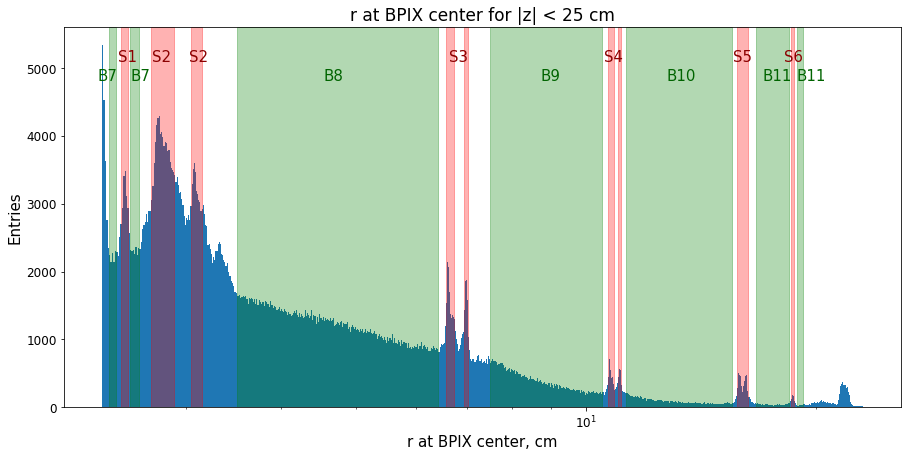

In [42]:
def makeBand(xStart, xWidth, px, bandColor):
    transperance = 0.3
    for p, lw in zip(xStart,xWidth):
        #plt.axvline(p, color=bandColor, alpha = transperance)
        px.axvspan(p, p+lw, alpha = transperance, color=bandColor)

def makeSBtext(xPos,yPos, px, text, textColor, fontS = 15):
    for i_xPos, i_text in zip(xPos,text):
        px.text(i_xPos, yPos, i_text,
                verticalalignment='bottom', horizontalalignment='left',
                transform=px.transAxes, color=textColor, fontsize=fontS)
    

plt.rc('axes', labelsize = 15)
plt.rc('axes', titlesize= 17)
plt.rc('font', size=12) 
plt.rc('legend', fontsize=15)

# the histogram of the data
Radius = np.sqrt(np.square(data[:,1])+np.square(data[:,2]))
Radius_BP = np.sqrt(np.square(data[:,1]-0.171)+np.square(data[:,2]+0.176))
Radius_BPIX = np.sqrt(np.square(data[:,1]-0.086)+np.square(data[:,2]+0.102))
Radius_Tube = np.sqrt(np.square(data[:,1]+0.080)+np.square(data[:,2]+0.318))

# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(15,7))
num_bins = 2000

#n, bins, patches = ax.hist(Radius[Radius < 25], num_bins)

#correction to BPIX
#n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(Radius_BPIX >2.33, Radius_BPIX <4)], num_bins)
n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(Radius_BPIX >2.33, Radius_BPIX <23)], num_bins)
# n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(np.logical_and(Radius_BPIX >2.33, Radius_BPIX <23),
#                                                       data[:,4] < 15)], num_bins)
# ax.set_xlim(2.33,23)
#plt.xlim(17,21)

# add a 'best fit' line
#y_min = (2.7)
#ax.plot(bins, y_min, '--')

#          Inner Shield      L1_1    L1_2    L2_1  L2_2     L3_1   L3_2      L4_1_2 Outer Shield      
xSignal_BPIX = [2.47,        2.7,    3.05,   6.56, 6.93,    10.68, 11.01,    15.75, 18.53]
lw_Signal_BPIX =  [0.055,    0.2,    0.1,    0.17,  0.09,     0.2,  0.12,      0.55, 0.2]
#lw_Signal_BPIX =  [0.055,       0.2, 0.1,    0.1,  0.09,     0.2,  0.12,      0.55, 0.2]
makeBand(xSignal_BPIX, lw_Signal_BPIX, ax, "red")

#              BP-S    S-L1    L1-L2  L2-L3  L3-L4   L4-OS   OS-Rails
xBkg_BPIX =   [2.38,   2.54,   3.5,   7.5,   11.3,   16.7,   18.9]
lw_Bkg_BPIX = [0.05,   0.07,   2.9,   3.0,   4.2,    1.7,    0.3]
makeBand(xBkg_BPIX, lw_Bkg_BPIX, ax, "green")
            
#n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(Radius_BPIX >2.4, Radius_BPIX <18)], num_bins)
Xtitle = "r at BPIX center"

# correcton to pixel support tube
#n, bins, patches = ax.hist(Radius_Tube[np.logical_and(Radius_Tube >20, Radius_Tube <25)], num_bins)
#Xtitle = "R_tube"

ax.set_xlabel(Xtitle+', cm')
ax.set_ylabel('Entries')
ax.set_title(Xtitle+' for |z| < 25 cm')

yBkgPos = 0.85
#background   befor L1    L1-L2 L2-L3 L3-L4  L4-TIB1
xBkgPos =    [0.04, 0.08, 0.31, 0.57, 0.72,  0.835, 0.875]
textPos =    ["B7", "B7", "B8", "B9", "B10", "B11", "B11"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, ax, textPos, "darkgreen")

ySPos = 0.9
#Signal    IS     L1           L2    L3     L4    OS
xSPos =   [0.065, 0.105, 0.15, 0.46, 0.646, 0.8,  0.86]
textPos = ["S1",  "S2",  "S2", "S3", "S4",  "S5", "S6"]
makeSBtext(xSPos, ySPos, ax, textPos, "darkred")

# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
plt.xscale('log')
#plt.yscale('log')
plt.savefig('Results/R_atBPIX.pdf')
plt.show()


## Set Signal and Background regions for beam pipe <a class="anchor" id="SetBP"></a>

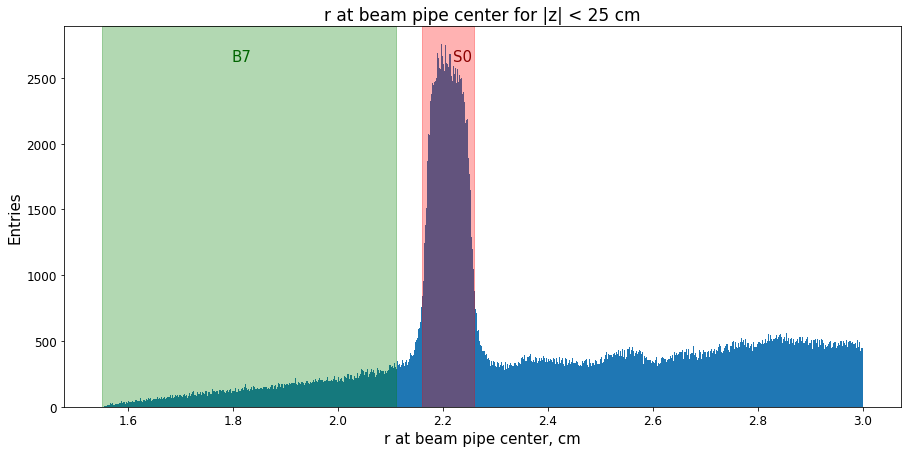

In [43]:
# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(15,7))
#num_bins = 180
num_bins = 1000

#correction to beam pipe
n, bins, patches = ax.hist(Radius_BP[Radius_BP < 3], num_bins)
#n, bins, patches = ax.hist(data[:,4][data[:,4] < 60], num_bins)
Xtitle = "r at beam pipe center"
#                BP      
xSignal_BP =    [2.16]
lw_Signal_BP =  [0.1]
makeBand(xSignal_BP, lw_Signal_BP, ax, "red")

#           before BP
xBkg_BP =   [1.55]
lw_Bkg_BP = [0.56]
makeBand(xBkg_BP, lw_Bkg_BP, ax, "green")

ax.set_xlabel(Xtitle+', cm')
ax.set_ylabel('Entries')
ax.set_title(Xtitle+' for |z| < 25 cm')

yBkgPos = 0.9
#background   befor BP
xBkgPos =    [0.2]
textPos =    ["B7"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, ax, textPos, "darkgreen")

ySPos = 0.9
#Signal    BP
xSPos =   [0.465]
textPos = ["S0"]
makeSBtext(xSPos, ySPos, ax, textPos, "darkred")

plt.savefig('Results/R_atBeamPipe.pdf')
plt.show()


## Set Signal and Background regions for pixel support tube <a class="anchor" id="SetTube"></a>

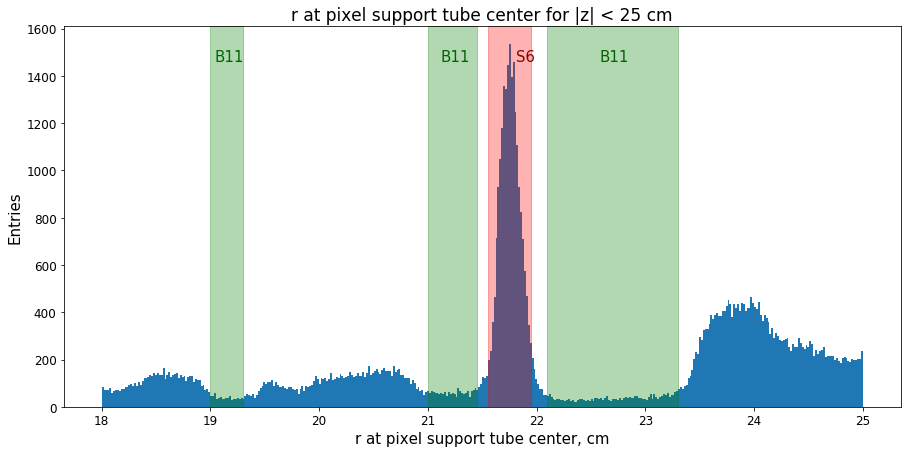

In [44]:
# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(15,7))
num_bins = 400

#correction to pixel support tube
n, bins, patches = ax.hist(Radius_Tube[np.logical_and(Radius_Tube >18, Radius_Tube <25)], num_bins)
Xtitle = "r at pixel support tube center"

#                  Tube     
xSignal_Tube   =  [21.55]
lw_Signal_Tube =  [0.4]
makeBand(xSignal_Tube, lw_Signal_Tube, ax, "red")

#             OS-Tube Rails-Tube Tube-TIB1
xBkg_Tube =   [19.,   21.,       22.1]
lw_Bkg_Tube = [0.3,   0.45,      1.2]
makeBand(xBkg_Tube, lw_Bkg_Tube, ax, "green")

ax.set_xlabel(Xtitle+', cm')
ax.set_ylabel('Entries')
ax.set_title(Xtitle+' for |z| < 25 cm')

#plt.xscale('log')
#plt.yscale('log')

yBkgPos = 0.9
#background   L4-TIB1
xBkgPos =    [0.18, 0.45, 0.64]
textPos =    ["B11", "B11", "B11"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, ax, textPos, "darkgreen")

ySPos = 0.9
#Signal    BPIX support tube
xSPos =   [0.54]
textPos = ["S6"]
makeSBtext(xSPos, ySPos, ax, textPos, "darkred")

plt.savefig('Results/R_atTube.pdf')
plt.show()

## Set Signal and Background regions  for rails, by using  x positon of NI ($\phi$ could be used too) <a class="anchor" id="SetRails"></a>

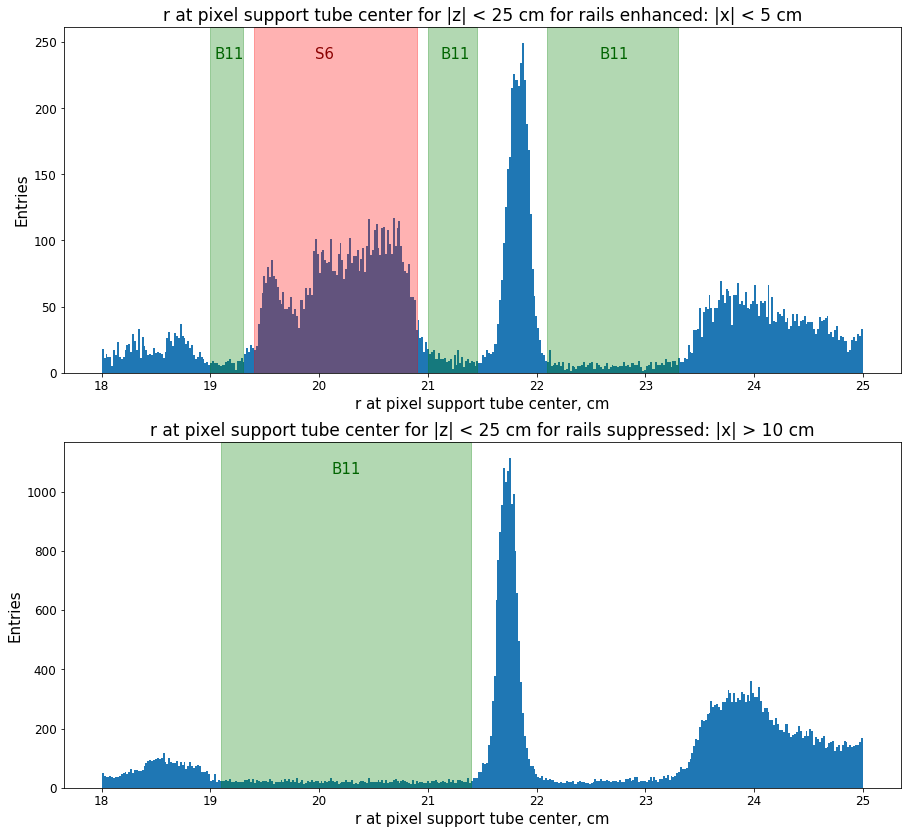

In [45]:
# using the variable ax for single a Axes
fig, (ax,bx) = plt.subplots(2,1, figsize=(15,14))
num_bins = 400

#correction to pixel support tube
n, bins, patches = ax.hist(Radius_Tube[np.logical_and(np.logical_and(Radius_Tube >18, Radius_Tube <25), 
                                                      np.logical_and(data[:,1]> -5, data[:,1]<5))], num_bins)
n_b, bins_b, patches_b = bx.hist(Radius_Tube[np.logical_and(np.logical_and(Radius_Tube >18, Radius_Tube <25), 
                                                            np.logical_or(data[:,1]< -10, data[:,1]>10))], num_bins)
Xtitle = "r at pixel support tube center"

#                  Rails     
xSignal_Rails   =  [19.4]
lw_Signal_Rails =  [1.5]
makeBand(xSignal_Rails, lw_Signal_Rails, ax, "red")

# the same background as for pixel support tube:
makeBand(xBkg_Tube, lw_Bkg_Tube, ax, "green")

ax.set_xlabel(Xtitle+', cm')
ax.set_ylabel('Entries')
ax.set_title(Xtitle+' for |z| < 25 cm for rails enhanced: |x| < 5 cm')


#                 noRails region: |PFDV_X| > 10 cm, PFDV_X = data[:,1]
xBkg_noRails =   [19.1]
lw_Bkg_noRails = [2.3]
makeBand(xBkg_noRails, lw_Bkg_noRails, bx, "green")
bx.set_xlabel(Xtitle+', cm')
bx.set_ylabel('Entries')
bx.set_title(Xtitle+' for |z| < 25 cm for rails suppressed: |x| > 10 cm')

#plt.xscale('log')
#plt.yscale('log')

yBkgPos = 0.9
#background   L4-TIB1
xBkgPos =    [0.18, 0.45, 0.64]
textPos =    ["B11", "B11", "B11"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, ax, textPos, "darkgreen")

ySPos = 0.9
#Signal    BPIX rails
xSPos =   [0.3]
textPos = ["S6"]
makeSBtext(xSPos, ySPos, ax, textPos, "darkred")

yBkgPos = 0.9
#background   L4-TIB1
xBkgPos =    [0.32]
textPos =    ["B11"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, bx, textPos, "darkgreen")

plt.savefig('Results/R_atTube_forRails.pdf')
plt.show()

## Classify events as Signal, as Background, and as Unclassified regions (-1) <a class="anchor" id="ClassifyEvents"></a>

In [46]:
def SetYval(xStart, xWidth, Yval, Rad):    
    for p, lw, yVal in zip(xStart, xWidth, Yval):
        logicVal = np.logical_and(Rad > p, Rad < (p+lw))
        # reshape from (n,) to (n,1)
        #logicVal = logicVal.reshape(Y.shape)
        # assinge yVal only if logicVal
        Y[logicVal] = yVal

def SetYvalRails(xStart, xWidth, Yval, Rad):
    for p, lw, yVal in zip(xStart, xWidth, Yval):
        logicVal = np.logical_and(np.logical_and(Rad > p, Rad < (p+lw)),
                                  np.logical_and(data[:,1] > -5, data[:,1] < 5))
        # assinge yVal only if logicVal
        Y[logicVal] = yVal        
def SetYvalnoRails(xStart, xWidth, Yval, Rad):
    for p, lw, yVal in zip(xStart, xWidth, Yval):
        logicVal = np.logical_and(np.logical_and(Rad > p, Rad < (p+lw)),
                                  np.logical_or(data[:,1] < -10, data[:,1] > 10))
        # assinge yVal only if logicVal
        Y[logicVal] = yVal 
        
logger.info ("data shape = "+str(data.shape))
Y = np.zeros((data.shape[0])) - 1
logger.info ("shape of Y = " +str(Y.shape))

#Define values for Y: 0-6 - Signal, 7-11 - Background:

#          Inner Shield L1_1 L1_2    L2_1  L2_2     L3_1   L3_2      L4_1_2 Outer Shield 
Y_Signal_BPIX = [1,     2,   2,      3,    3,       4,     4,        5,     6]
logger.debug("Signal       BPIX = " + str(xSignal_BPIX))
logger.debug("Signal width BPIX = " + str(lw_Signal_BPIX))
#              BP-S    S-L1    L1-L2  L2-L3  L3-L4   L4-OS   OS-Rails
Y_Bkg_BPIX =   [7,     7,      8,     9,     10,     11,     11]
logger.debug("Bkg          BPIX = " + str(xBkg_BPIX))
logger.debug("BKg    width BPIX = " + str(lw_Bkg_BPIX))

Y_Signal_BP = [0]
logger.debug("Signal       BP = " + str(xSignal_BP))
logger.debug("Signal width BP = " + str(lw_Signal_BP))
Y_Bkg_BP = [7]
logger.debug("Bkg          BP = " + str(xBkg_BP))
logger.debug("Bkg    width BP = " + str(lw_Bkg_BP))

# Tube
Y_Signal_Tube = [6]
logger.debug("Signal       Tube = " + str(xSignal_Tube))
logger.debug("Signal width Tube = " + str(lw_Signal_Tube))
#             OS-Tube Rails-Tube Tube-TIB1
Y_Bkg_Tube = [11, 11, 11]
logger.debug("Bkg          Tube = " + str(xBkg_Tube))
logger.debug("Bkg    width Tube = " + str(lw_Bkg_Tube))

# Special case for Rails with cut on PFDV_X
#                 Rails region: |PFDV_X| < 5 cm, PFDV_X = data[:,1]
#                 the same background as for Tube
Y_Signal_Rails = [6]
logger.debug("Signal       Rails = " + str(xSignal_Rails))
logger.debug("Signal width Rails = " + str(lw_Signal_Rails))
#                 noRails region: |PFDV_X| > 10 cm, PFDV_X = data[:,1]
#             OS-Tube
Y_Bkg_noRails = [11]
logger.debug("Bkg          noRails = " + str(xBkg_noRails))
logger.debug("Bkg    width noRails = " + str(lw_Bkg_noRails))

# Set up valuse for Y: start with Singnal, finish with Background

SetYval(xSignal_BPIX, lw_Signal_BPIX, Y_Signal_BPIX, Radius_BPIX)
SetYval(xBkg_BPIX, lw_Bkg_BPIX, Y_Bkg_BPIX, Radius_BPIX)
#print (str(Y[500:700]))
SetYval(xSignal_BP, lw_Signal_BP, Y_Signal_BP, Radius_BP)
SetYval(xBkg_BP, lw_Bkg_BP, Y_Bkg_BP, Radius_BP)
SetYval(xSignal_Tube, lw_Signal_Tube, Y_Signal_Tube, Radius_Tube)
SetYval(xBkg_Tube, lw_Bkg_Tube, Y_Bkg_Tube, Radius_Tube)
#print (str(Y[500:700]))
SetYvalRails(xSignal_Rails, lw_Signal_Rails, Y_Signal_Rails, Radius_Tube)
SetYvalnoRails(xBkg_noRails, lw_Bkg_noRails, Y_Bkg_noRails, Radius_Tube)
#print (str(Y[500:700]))

logger.debug ("count (Y >= 0) = %d " % (np.count_nonzero(Y >= 0)))
for i in range(-1,12):
    logger.debug ("count (Y = %d) = %d " % (i, np.count_nonzero(Y == i)))

INFO:log:data shape = (1397381, 27)
INFO:log:shape of Y = (1397381,)
DEBUG:log:Signal       BPIX = [2.47, 2.7, 3.05, 6.56, 6.93, 10.68, 11.01, 15.75, 18.53]
DEBUG:log:Signal width BPIX = [0.055, 0.2, 0.1, 0.17, 0.09, 0.2, 0.12, 0.55, 0.2]
DEBUG:log:Bkg          BPIX = [2.38, 2.54, 3.5, 7.5, 11.3, 16.7, 18.9]
DEBUG:log:BKg    width BPIX = [0.05, 0.07, 2.9, 3.0, 4.2, 1.7, 0.3]
DEBUG:log:Signal       BP = [2.16]
DEBUG:log:Signal width BP = [0.1]
DEBUG:log:Bkg          BP = [1.55]
DEBUG:log:Bkg    width BP = [0.56]
DEBUG:log:Signal       Tube = [21.55]
DEBUG:log:Signal width Tube = [0.4]
DEBUG:log:Bkg          Tube = [19.0, 21.0, 22.1]
DEBUG:log:Bkg    width Tube = [0.3, 0.45, 1.2]
DEBUG:log:Signal       Rails = [19.4]
DEBUG:log:Signal width Rails = [1.5]
DEBUG:log:Bkg          noRails = [19.1]
DEBUG:log:Bkg    width noRails = [2.3]
DEBUG:log:count (Y >= 0) = 950473 
DEBUG:log:count (Y = -1) = 446908 
DEBUG:log:count (Y = 0) = 153558 
DEBUG:log:count (Y = 1) = 16735 
DEBUG:log:count (Y = 2

## Estimate background under each structure regions

Estimation is done by sidebend technique:

$B_{underS}(w) = B_{before}(w/2) + B_{after}(w/2) $, where w is a width of the signal region.


Also, signal weight for cross entropy is estimapted: $w_{Signal} = B_{estimated}/S_{estimated} $, where

$S_{estimated} = All_{underS} - B_{underS}$ and $B_{estimated} = B_{underB} + B_{underS}$ 

In [119]:
# Background under beam pipe

def BtoS_BP(Rad):
    ratio = 0.
    # width BP
    width_S = lw_Signal_BP[0]
    S_left = xSignal_BP[0]
    
    # backgound before beam pipe is finished
    B_left = xBkg_BP[0] + lw_Bkg_BP[0]
    # beckground after beam pipe is start
    B_right = 2.3
    # count backgound 
    B_underS = np.count_nonzero(np.logical_and(Rad > (B_left - width_S/2),Rad < B_left)) + np.count_nonzero(np.logical_and(Rad > B_right,Rad < (B_right + width_S/2)))
    SandB_udnerS = np.count_nonzero(np.logical_and(Rad > (S_left),Rad < (S_left+width_S)))
    S_underS = SandB_udnerS - B_underS
    ratio = B_underS/S_underS
    return ratio, S_underS, B_underS


# Background under BPIX (IS, L1-L4, OS)

def BtoS_BPIX(Rad,Name = "L1"):
    ratio = 0.
    if Name == "IS":
        iS = 0
        iS2 = 0 # don't use iS2 if for IS
        iB_left = 0
        iB_right = 1
    elif Name == "L1":
        iS = 1
        iS2 = 2
        iB_left = 1
        iB_right = 2
    elif Name == "L2":
        iS = 3
        iS2 = 4
        iB_left = 2
        iB_right = 3
    elif Name == "L3":
        iS = 5
        iS2 = 6
        iB_left = 3
        iB_right = 4
    elif Name == "L4":
        iS = 7
        iS2 = 7 # don't use iS2 if for L4
        iB_left = 4
        iB_right = 5
    elif Name == "OS":
        iS = 8
        iS2 = 8 # don't use iS2 if for L4
        iB_left = 5
        iB_right = 6
    else:
        print("Error in BtoS_BPIX: Name structure is not correct")
    
    width_S = lw_Signal_BPIX[iS]
    S_left  = xSignal_BPIX[iS]
    width_S2 = lw_Signal_BPIX[iS2]
    S2_left  = xSignal_BPIX[iS2]
    # backgound before structure is finished
    B_left = xBkg_BPIX[iB_left] + lw_Bkg_BPIX[iB_left]
    # beckground after structure is start
    B_right = xBkg_BPIX[iB_right]
    # count backgound
    if Name == "IS" or Name == "L4" or Name == "OS": # one signal region
        B_underS = np.count_nonzero(np.logical_and(Rad > (B_left - width_S/2),Rad < B_left)) + np.count_nonzero(np.logical_and(Rad > B_right,Rad < (B_right + width_S/2)))
        SandB_udnerS = np.count_nonzero(np.logical_and(Rad > (S_left),Rad < (S_left+width_S)))
    elif Name == "L1": # 2 signal regions with narrow backgound at left
        Bwidth_left = lw_Bkg_BPIX[iB_left]
        # scale left nerrow backgound slice to (width_S+width_S2)
        Scale_left = (width_S+width_S2)/2/Bwidth_left
#         print("Type of Scale_left = " + str(type(Scale_left)))
        B_underS = np.count_nonzero(np.logical_and(Rad > (B_left - Bwidth_left),Rad < B_left))
        B_underS = Scale_left*B_underS 
        B_underS = B_underS + np.count_nonzero(np.logical_and(Rad > B_right,Rad < (B_right + (width_S+width_S2)/2)))
        SandB_udnerS = np.count_nonzero(np.logical_and(Rad > (S_left),Rad < (S_left+width_S)))
        SandB_udnerS = SandB_udnerS + np.count_nonzero(np.logical_and(Rad > (S2_left),Rad < (S2_left+width_S2)))
        
    elif Name == "L2" or Name == "L3": # 2 signal regions
        B_underS = np.count_nonzero(np.logical_and(Rad > (B_left - (width_S+width_S2)/2),Rad < B_left))
        B_underS = B_underS + np.count_nonzero(np.logical_and(Rad > B_right,Rad < (B_right + (width_S+width_S2)/2)))
        SandB_udnerS = np.count_nonzero(np.logical_and(Rad > (S_left),Rad < (S_left+width_S)))
        SandB_udnerS = SandB_udnerS + np.count_nonzero(np.logical_and(Rad > (S2_left),Rad < (S2_left+width_S2)))
        
    S_underS = SandB_udnerS - B_underS
    ratio = B_underS/S_underS
    return ratio, S_underS, B_underS

# Backgorund under Tube 
def BtoS_Tube(Rad):
    ratio = 0.
    # width BP
    width_S = lw_Signal_Tube[0]
    S_left = xSignal_Tube[0]
    
    # backgound before beam pipe is finished
    B_left = xBkg_Tube[1] + lw_Bkg_Tube[1]
    # beckground after beam pipe is start
    B_right = xBkg_Tube[2]
    # count backgound 
    B_underS = np.count_nonzero(np.logical_and(Rad > (B_left - width_S/2),Rad < B_left)) + np.count_nonzero(np.logical_and(Rad > B_right,Rad < (B_right + width_S/2)))
    SandB_udnerS = np.count_nonzero(np.logical_and(Rad > (S_left),Rad < (S_left+width_S)))

    S_underS = SandB_udnerS - B_underS
    ratio = B_underS/S_underS
    return ratio, S_underS, B_underS  

# Backgorund under Rails 
def BtoS_Rails(Rad, X_Rails):
    ratio = 0.
    # width BP
    width_S = lw_Signal_Rails[0]
    S_left = xSignal_Rails[0]
    
    # backgound before beam pipe is finished
    B_left = xBkg_Tube[0] + lw_Bkg_Tube[0] # the same bkg as for Tube
    Bwidth_left = lw_Bkg_Tube[0]
    # scale left nerrow backgound slice to width_S
    Scale_left = width_S/2/Bwidth_left
    # beckground after beam pipe is start
    B_right = xBkg_Tube[1]
    Bwidth_right = lw_Bkg_Tube[1]
    # scale left nerrow backgound slice to width_S
    Scale_right = width_S/2/Bwidth_right
        
    # count backgound 
    B_underS = Scale_left* np.count_nonzero(np.logical_and(np.abs(X_Rails) < 5, 
                                                           np.logical_and(Rad > (B_left - Bwidth_left),Rad < B_left)))
    B_underS = B_underS + Scale_right*np.count_nonzero(np.logical_and(np.abs(X_Rails) < 5, 
                                                                      np.logical_and(Rad > B_right,Rad < (B_right + Bwidth_right))))
    SandB_udnerS = np.count_nonzero(np.logical_and(np.abs(X_Rails) < 5, np.logical_and(Rad > (S_left), Rad < (S_left+width_S))))

    S_underS = SandB_udnerS - B_underS
    ratio = B_underS/S_underS
    return ratio, S_underS, B_underS

# Backgorund under Background  
def BtoS_Bkg(Rad_BP, Rad_BPIX, Rad_Tube):
    ratio = 1000. # there is not signal at background region
        
    # count backgound before BP:
    Bx = xBkg_BP[0]
    Bwidth = lw_Bkg_BP[0] 
    B_underB = np.count_nonzero(np.logical_and(Rad_BP > Bx,Rad_BP < (Bx + Bwidth)))
    
    for Bx, Bwidth in zip(xBkg_BPIX, lw_Bkg_BPIX):
        B_underB = B_underB + np.count_nonzero(np.logical_and(Rad_BPIX > Bx,Rad_BPIX < (Bx + Bwidth)))
    for Bx, Bwidth in zip(xBkg_Tube, lw_Bkg_Tube):
        B_underB = B_underB + np.count_nonzero(np.logical_and(Rad_Tube > Bx,Rad_Tube < (Bx + Bwidth)))

    S_underB = 0.
    return ratio, S_underB, B_underB

# for NN injections:
MaterialOfInterest_NN = ["BP", "L2", "L3", "L4", "Tube", "Rails", "Background"]
# MaterialOfInterest_NN = ["BP", "L2", "L3", "L4", "Background"]
#MaterialOfInterest_NN = ["L2", "L3", "L4", "Tube", "Rails", "Background"]
#MaterialOfInterest_NN = ["L2"]
# MaterialOfInterest_NN =["BP", "IS","L1","L2", "L3", "L4","OS", "Tube", "Rails", "Background"]
# for NN injections without background:
MaterialOfInterest_NN_noBkg = ["BP", "L2", "L3", "L4", "Tube", "Rails"]
# for all structures:
MaterialOfInterest_All = ["BP", "IS","L1","L2", "L3", "L4","OS", "Tube", "Rails", "Background"]
# Pixel material:
MaterialOfPixel =    ["IS","L1", "L2", "L3", "L4", "OS"]

# f = MaterialOfInterest[0]
# print('before comparison f: '+str(f))
# if any(f == x for x in MaterialOfPixel):
#     print('f: '+str(f))

def PreReF1(Rad_BP, Rad_BPIX, Rad_Tube, X_Rails, Mat, Mat_Pixel):    

    prec_Mat, recall_Mat, f1_Mat= 0., 0., 0.
    tp, tn, fp, fn = 0., 0., 0., 0.
    
    lenth = np.size(Mat)
#     logger.debug("np.size(Mat) = " + str(np.size(Mat)))
    S_estimate = np.zeros(lenth)
    B_estimate = np.zeros(lenth)
    ratio_estimate = np.zeros(lenth)

    for i in range(0,lenth):
        if Mat[i] == "BP":
            ratio_estimate[i], S_estimate[i], B_estimate[i] = BtoS_BP(Rad_BP)
            fp = fp + B_estimate[i]
        if any(Mat[i] == x for x in Mat_Pixel):
            ratio_estimate[i], S_estimate[i], B_estimate[i] = BtoS_BPIX(Rad_BPIX, Mat[i])
            fp = fp + B_estimate[i]
        elif Mat[i] == "Tube":
            ratio_estimate[i], S_estimate[i], B_estimate[i] = BtoS_Tube(Rad_Tube)
            fp = fp + B_estimate[i]
        elif Mat[i] == "Rails":
            ratio_estimate[i], S_estimate[i], B_estimate[i] = BtoS_Rails(Rad_Tube, X_Rails)
            fp = fp + B_estimate[i]
        elif Mat[i] == "Background":
            ratio_estimate[i], S_estimate[i], B_estimate[i] = BtoS_Bkg(Rad_BP, Rad_BPIX, Rad_Tube)
            tn = tn + B_estimate[i]

#         logger.info("Ratio(B/S) at %s = %3.2f, signal = %7.0f, and background = %7.0f" % 
#                     (Mat[i],ratio_estimate[i], S_estimate[i], B_estimate[i]))
        
    # calculated f1score
    tp = np.sum(S_estimate)
    fn = 0.
    epsilon = 1.0e-6
    #logger.debug("tp = " + str(tp) + "fp = " + str(fp))
    B_est_tot = np.sum(B_estimate)
    w_Signal = B_est_tot/(tp+epsilon)

    prec_Mat = tp / (tp + fp + epsilon)
    recall_Mat = tp / (tp + fn + epsilon)

    f1_Mat = 2*prec_Mat*recall_Mat / (prec_Mat+recall_Mat+epsilon)
#     f1_Mat = f1*r # correct to f1_loss more weithg for recall
##    f1 = f1*np.sqrt(r) # correct to f1_loss more weithg for recall

    return ratio_estimate, S_estimate, B_estimate, prec_Mat, recall_Mat, f1_Mat, w_Signal

ratio_est, S_est, B_est, prec_NN, recall_NN, f1Score_NNinjected, wSignal_NN = PreReF1(Radius_BP, Radius_BPIX, 
                                                                                      Radius_Tube, data[:,1], 
                                                                                      MaterialOfInterest_NN, 
                                                                                      MaterialOfPixel)[0:7]
# wSignal_NN = PreReF1(Radius_BP, Radius_BPIX, Radius_Tube, data[:,1], MaterialOfInterest_NN, MaterialOfPixel)[6]

lenth = np.size(B_est)

for i in range(0,lenth):
    logger.info("Ratio(B/S) at %s = %4.2f, signal = %7.0f, and background = %7.0f" % 
                (MaterialOfInterest_NN[i],ratio_est[i], S_est[i], B_est[i]))
        
logger.info(" Selected material: precison = %3.3f, recall =  %3.2f, f1 score =  %3.2f" % 
            (prec_NN, recall_NN, f1Score_NNinjected))

logger.debug("f1Score_NNinjected = " + str(f1Score_NNinjected))
logger.info("recommended signal weight for NN = " + str(wSignal_NN))

INFO:log:Ratio(B/S) at BP = 0.16, signal =  132797, and background =   20761
INFO:log:Ratio(B/S) at L2 = 0.92, signal =   20964, and background =   19363
INFO:log:Ratio(B/S) at L3 = 0.71, signal =    8829, and background =    6232
INFO:log:Ratio(B/S) at L4 = 0.17, signal =   17059, and background =    2848
INFO:log:Ratio(B/S) at Tube = 0.06, signal =   18982, and background =    1105
INFO:log:Ratio(B/S) at Rails = 0.13, signal =    5820, and background =     764
INFO:log:Ratio(B/S) at Background = 1000.00, signal =       0, and background =  569707
INFO:log: Selected material: precison = 0.800, recall =  1.00, f1 score =  0.89
DEBUG:log:f1Score_NNinjected = 0.8889648082479406
INFO:log:recommended signal weight for NN = 3.0363298429384256


## Check classification result <a class="anchor" id="CheckClassification"></a>

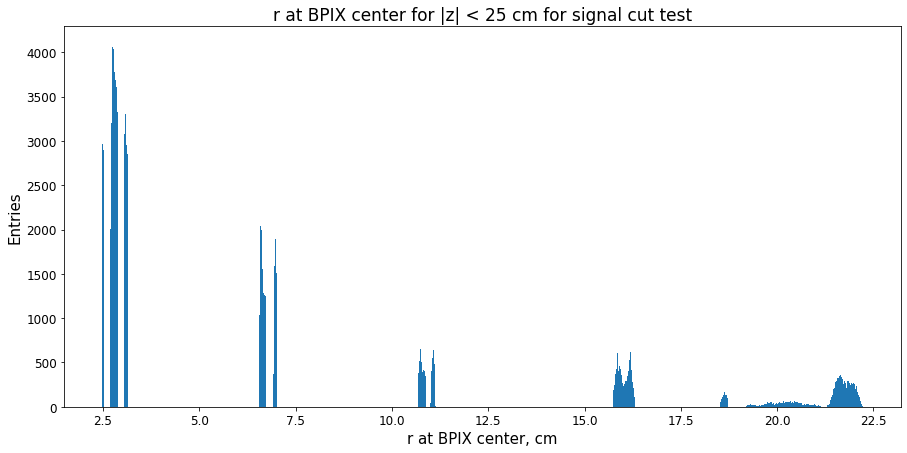

In [48]:
# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(15,7))
num_bins = 2000

#n, bins, patches = ax.hist(Radius[Radius < 25], num_bins)

#correction to BPIX
#Signal
n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(np.logical_and(Radius_BPIX >2.33, Radius_BPIX <23),
                                                      np.logical_and(Y > 0, Y < 7))], num_bins)
# n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(np.logical_and(Radius_BPIX >2.33, Radius_BPIX <23),
#                                                       Y == 9)], num_bins)
#Signal for Beam pipe
# n, bins, patches = ax.hist(Radius_BP[np.logical_and(np.logical_and(Radius_BP >1., Radius_BP <3),
#                                                    Y ==0)], num_bins)
#Background
#n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(np.logical_and(Radius_BPIX >1., Radius_BPIX <23),
#                                                      np.logical_and(Y > 6, Y < 12))], num_bins)
#Background after L4
#n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(np.logical_and(Radius_BPIX >2.33, Radius_BPIX <23),
#                                                      Y == 11)], num_bins)

#plt.xlim(17,21)

            
#n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(Radius_BPIX >2.4, Radius_BPIX <18)], num_bins)
Xtitle = "r at BPIX center"


ax.set_xlabel(Xtitle+', cm')
ax.set_ylabel('Entries')
ax.set_title(Xtitle+' for |z| < 25 cm for signal cut test')

# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('Results/R_atBPIX_testSignalCuts.pdf')
plt.show()

## Shuffle Data <a class="anchor" id="DataShufle"></a>

Important: 

before shuffling random seed was fixed to result to the same splitting for Train and Test sets each time running the code. It is nessasary for using trained model: we have to know on which data model was trained. 

In [49]:
#X_NN = data[:,4:27] # it will be set later, because we need to know R for Test set to plot it...
X_NN_orig = data

# set rendom seed to avoid different spitting for Train and Test sets each time
np.random.seed(1)
perm = np.random.permutation(X_NN_orig.shape[0])
logger.info("shape of perm = " + str(perm.shape))
#print ("perm = " + str(perm[1:100]))

# permutate X_NN_orig and Y: remove bias, when some parts of detector where not working for exampe...
X_NN_orig = X_NN_orig[perm]
Y_NN    = Y[perm]

INFO:log:shape of perm = (1397381,)


## Sort tracks parameters by $p_T$ decreasing and normalize subleading $p_T$ tracks <a class="anchor" id="SortPt"></a>

In [50]:
TrackNorm = True # sorting by pT decreasing and normalize subleading pT tracks
#TrackNorm = False # no sorting, no scaling

def elements(array):
    return array.ndim and array.size

# Create index fore each trackers' parameter:

#                      pT eta phi chi2 normalizedChi2 numberOfValidHits algorithm
IndexTrk = np.array([6, 9,  12, 15,  18,            21,               24])
#print ("IndexTrk[0] = " +str(IndexTrk[0]))

numTrk = 3 # 3 tracks per vertex
IndexNI = 6 # start from pT of tracks

Xpt = X_NN_orig[:, IndexNI:(IndexNI+numTrk)]

logger.debug("Xpt befor sort shape = " +str(Xpt.shape))
logger.debug("Xpt befor sort = " +str(Xpt[1:10,:]))

# sorting by decreasing (1st element is max,....)
argSortXpt = np.argsort(-Xpt, axis=1)
Xpt = np.array(list(map(lambda x, y: y[x], argSortXpt, Xpt)))

# Keep max pt track (1st track) and other tracks scale to it
Xpt[:,1:] = Xpt[:,1:]/Xpt[:,0].reshape(Xpt[:,0].size,1)

logger.debug("Xpt after sort = " +str(Xpt[1:10,:]))
logger.debug("argsort of Xpt = " +str(argSortXpt[1:10,:]))

# other parameters of tracks should be sorted the same way as pt (like eta, phi, chi2...)
#Xtrk_other = []
Xtrk_other = np.array([])

for i_par in range(1,7):
    Xtrk = X_NN_orig[:,(IndexNI+numTrk*i_par) : (IndexNI+numTrk*(i_par+1))]
    Xtrk = np.array(list(map(lambda x, y: y[x], argSortXpt, Xtrk)))
    #if elements(Xtrk_other) == 0 : # check if matrix is empty
    if i_par == 1 : # check if matrix is empty 
        Xtrk_other = Xtrk
    else:
        Xtrk_other = np.c_[Xtrk_other,Xtrk]

logger.debug("X_NN_orig before sort = " +str(X_NN_orig[1:10,9:]))
logger.debug("Xtrk_other after sort = " +str(Xtrk_other[1:10,:]))  

Xvertex = np.c_[Xpt,Xtrk_other]
if TrackNorm == True:
    X_NN = X_NN_orig
    X_NN[:, IndexNI:] = Xvertex
    logger.debug("X_NN after norm pT = " +str(X_NN[1:10,6:]))

DEBUG:log:Xpt befor sort shape = (1397381, 3)
DEBUG:log:Xpt befor sort = [[ 0.908355  1.212649  0.576789]
 [ 0.59097   0.725606  0.540003]
 [ 0.761741  0.59146  33.61713 ]
 [ 0.658883  0.377729  1.34921 ]
 [ 0.666954  0.549816  0.801325]
 [ 0.450999  0.358888  0.841195]
 [ 0.346372  0.493949  0.511961]
 [ 0.811048  2.268978  1.32329 ]
 [ 1.002888  6.892637  2.035569]]
DEBUG:log:Xpt after sort = [[1.21264900e+00 7.49066713e-01 4.75643818e-01]
 [7.25606000e-01 8.14450266e-01 7.44209668e-01]
 [3.36171300e+01 2.26593109e-02 1.75940064e-02]
 [1.34921000e+00 4.88347255e-01 2.79963090e-01]
 [8.01325000e-01 8.32313980e-01 6.86133591e-01]
 [8.41195000e-01 5.36140847e-01 4.26640672e-01]
 [5.11961000e-01 9.64817633e-01 6.76559347e-01]
 [2.26897800e+00 5.83209709e-01 3.57450799e-01]
 [6.89263700e+00 2.95325142e-01 1.45501352e-01]]
DEBUG:log:argsort of Xpt = [[1 0 2]
 [1 0 2]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 0 1]
 [2 1 0]
 [1 2 0]
 [1 2 0]]
DEBUG:log:X_NN_orig before sort = [[ 1.396972  1.326381  1.5

## Plot variables, injected to NN <a class="anchor" id="VariablesToNN"></a>
Select region of interest

In [15]:
import ipywidgets as widgets

d = widgets.Dropdown(options=['beam pipe', 'BPIX layer 1', 'BPIX layer 2', 'BPIX layer 3', 'BPIX layer 4', 'Tube/Rails'], value=None)
d


Dropdown(options=('beam pipe', 'BPIX layer 1', 'BPIX layer 2', 'BPIX layer 3', 'BPIX layer 4', 'Tube/Rails'), …

In [199]:
# Default is beam pipe region:
ys = 0 # BP
yb = 8 # background after BP & layer 1

if d.value == 'BPIX layer 1':
    ys = 2 # l1
    yb = 8
elif d.value == 'BPIX layer 2':
    ys = 3 # l2
    yb = 9
elif d.value == 'BPIX layer 3':
    ys = 4 # l3
    yb = 10
elif d.value == 'BPIX layer 4':
    ys = 5 # l4
    yb = 11 
elif d.value == 'Tube/Rails':
    ys = 6 # Tube and Raisl
    yb = 11 

logger.info("Region = " + str(d.value) + " is selected -> ys = " + str(ys) + " and yb = " + str(yb))

INFO:log:Region = BPIX layer 2 is selected -> ys = 3 and yb = 9


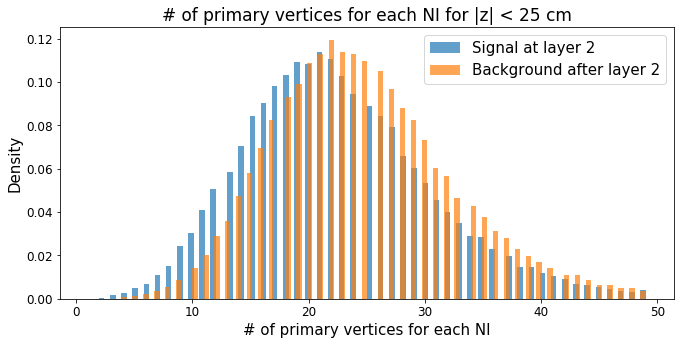

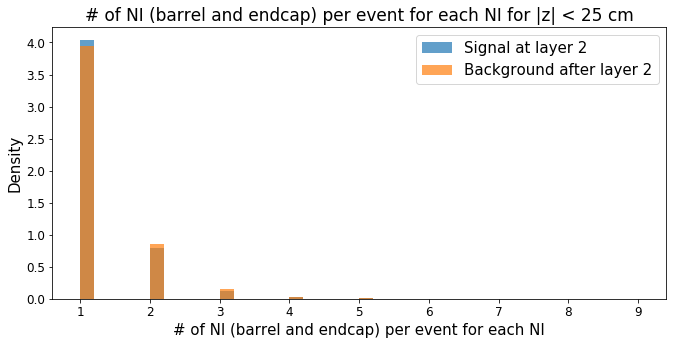

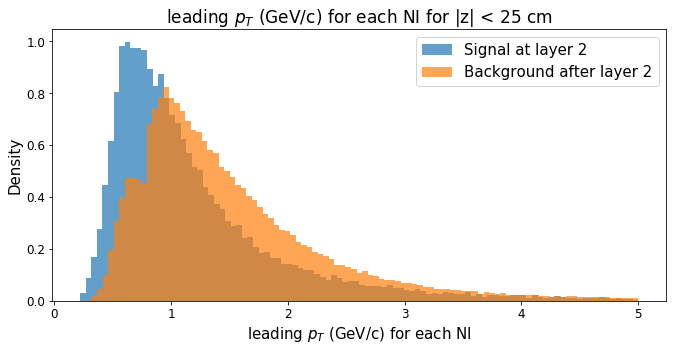

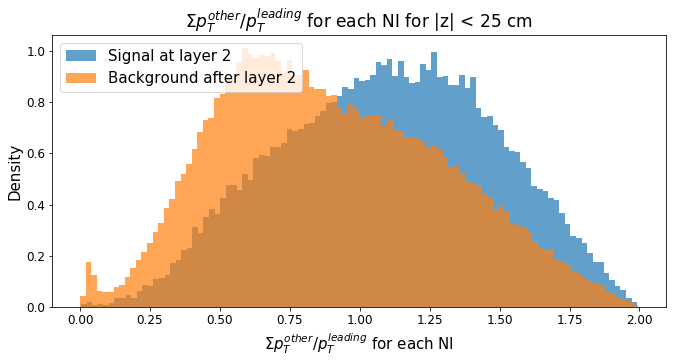

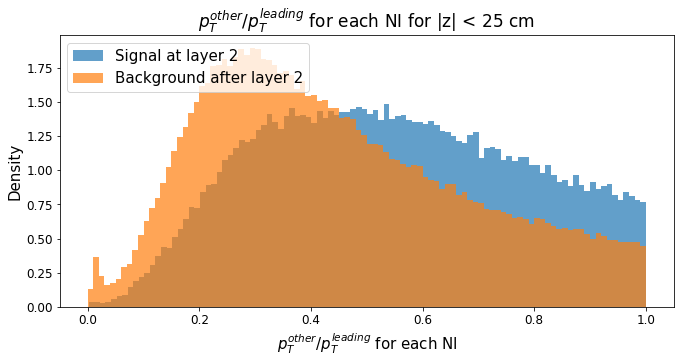

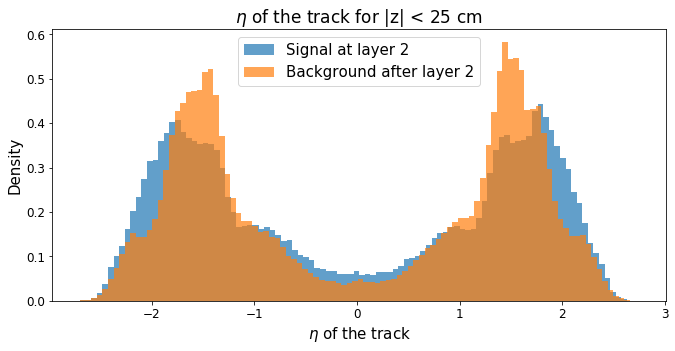

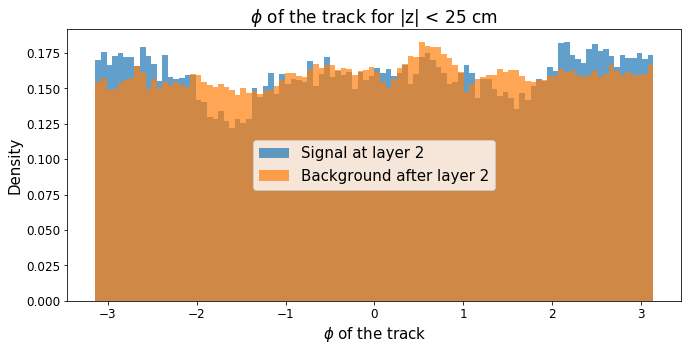

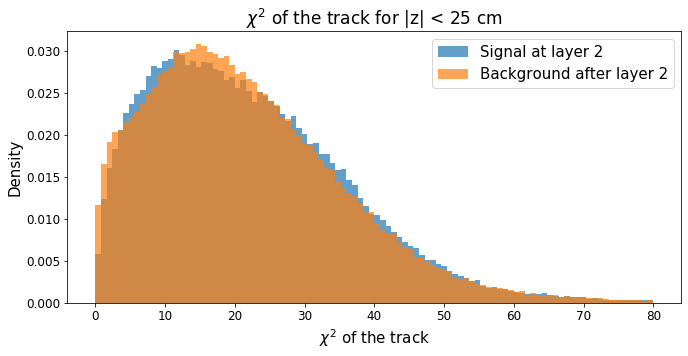

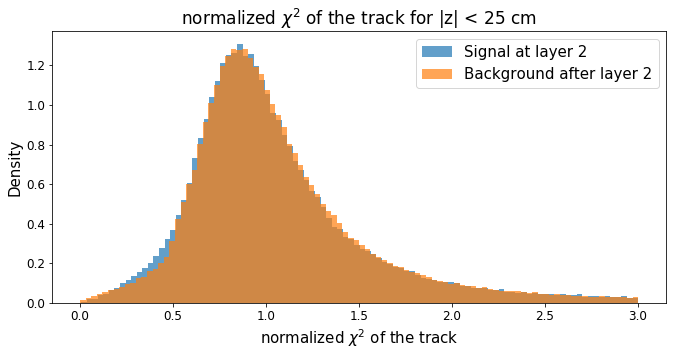

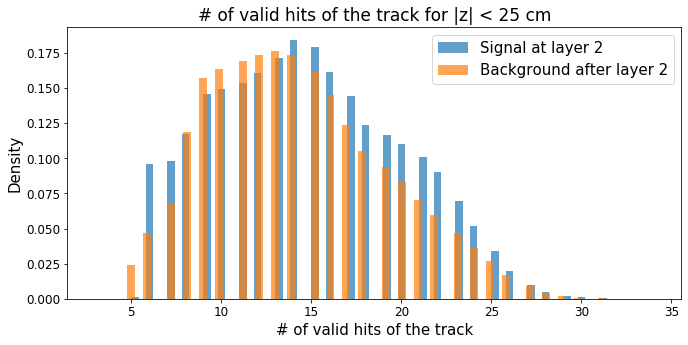

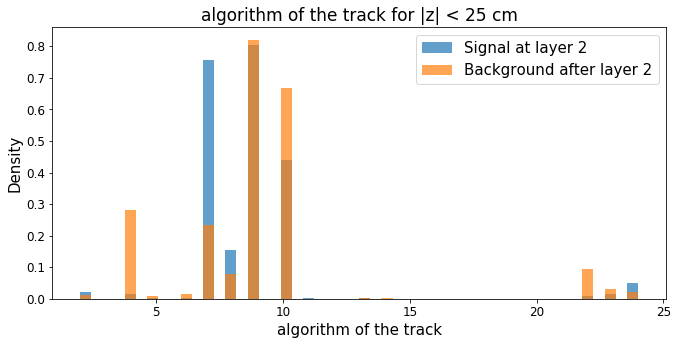

In [200]:
def PlotSvsBkg(index_var, varName, picName, num_bins, xmin, xmax, Y_S, Y_B, numPar, locPos = 'upper right'):
    fig, ax = plt.subplots(figsize=(11,5))


    XFill = X_NN[:, index_var]
    YFill = Y_NN
    # Fill (n >1) parameters Track 1, ... numPar
    if numPar > 1:
        for i_var in range(1,numPar):
            XFill = np.concatenate(([XFill,X_NN[:, index_var+i_var]]),axis=0)
            YFill =  np.concatenate(([YFill,Y_NN]),axis=0)

    flagSigma = "\Sigma" in varName
    if numPar == 2 and flagSigma: # it will work only for \Sigma pT and only there nunPar = 2
        XFill = X_NN[:, index_var] +X_NN[:, index_var+1]
        YFill = Y_NN 
        
#     # Fill 3 parameters Track 1, 2 and 3
#     if numPar == 3:
#         XFill = np.concatenate(([X_NN[:, index_var], X_NN[:, index_var+1], X_NN[:, index_var+2]]),axis=0)
#         YFill =  np.concatenate(([Y_NN,Y_NN,Y_NN]),axis=0)
#     else:
#         XFill = X_NN[:, index_var]
#         YFill = Y_NN


    #Signal
    n, bins, patches = ax.hist(XFill[np.logical_and(YFill == Y_S,XFill < xmax)], 
                               num_bins, density = True, alpha = 0.7)
    n, bins, patches = ax.hist(XFill[np.logical_and(YFill == Y_B,XFill < xmax)], 
                               num_bins, density = True, alpha = 0.7)


    if numPar == 3:
        Xtitle = varName + " of the track"
    else:
        Xtitle = varName + " for each NI"
    
    ax.set_xlabel(Xtitle)
    ax.set_ylabel('Density')
    ax.set_title(Xtitle +' for |z| < 25 cm')
    if Y_S == 0 and Y_B == 8:
        ax.legend(['Signal at beam pipe (BP)', 'Background after BP & layer 1'], loc=locPos)
    elif Y_S == 5 and Y_B == 11:
        ax.legend(['Signal at layer 4', 'Background after layer 4'], loc=locPos)
    elif Y_S == 2 :
        ax.legend(['Signal at layer 1', 'Background after layer 1'], loc=locPos)
    elif Y_S == 3 :
        ax.legend(['Signal at layer 2', 'Background after layer 2'], loc=locPos)
    elif Y_S == 4 :
        ax.legend(['Signal at layer 3', 'Background after layer 3'], loc=locPos)
    elif Y_S == 6 :
        ax.legend(['Signal at Tube and Rails', 'Background around Tube and Rails'], loc=locPos)
    else:
        ax.legend(['Signal', 'Background'], loc=locPos)

    # Tweak spacing to prevent clipping of ylabel
    #fig.tight_layout()
    #plt.xscale('log')
    #plt.yscale('log')
    if Y_S == 0:
        plt.savefig('Results/ControlPlots_BP_'+picName+'.pdf')
    elif Y_S == 5:
        plt.savefig('Results/ControlPlots_l4_'+picName+'.pdf')
    elif Y_S == 2:
        plt.savefig('Results/ControlPlots_l1_'+picName+'.pdf')
    elif Y_S == 3:
        plt.savefig('Results/ControlPlots_l2_'+picName+'.pdf')
    elif Y_S == 4:
        plt.savefig('Results/ControlPlots_l3_'+picName+'.pdf')
    else:
        plt.savefig('Results/ControlPlots_'+picName+'.pdf')
    plt.show()
    

# ys = 3 # l2
# yb = 9
# Y_S and Y_B are for 7 signal + 4 bkg befor converting to 4 categories
#          index_var, varName, picName num_bins, xmin, xmax, Y_S, Y_B,    numPar locPos
# for BP and bkg BP
PlotSvsBkg(4,         "# of primary vertices","numPV",  100,      0.,   50., ys, yb, 1)
PlotSvsBkg(5,         "# of NI (barrel and endcap) per event","numPFDV",  40,      0.,   10.,    ys, yb, 1)
if TrackNorm == False:
    PlotSvsBkg(6,          "$p_T$ (GeV/c)",   "pt",   100,      0.,   2.,    ys, yb, 3)
else:
    PlotSvsBkg(6,          "leading $p_T$ (GeV/c)",   "pt_leading",   100,      0.,   5.,    ys, yb, 1)
    # plot it till 2. to be sure that we don't have anything above 1, and when it sum it could be till 2:
    PlotSvsBkg(7,          "$\Sigma p_T^{other}/p_T^{leading}$",   "SumPtToLeading",   100,      0.,   2.,    ys, yb, 2, "upper left")
    PlotSvsBkg(7,          "$p_T^{other}/p_T^{leading}$",   "PtToLeading",   100,      0.,   2.,    ys, yb, 2, "upper left")
PlotSvsBkg(9,          "$\eta$", "eta",  100,      -5.,   5.,    ys, yb, 3, "upper center")
PlotSvsBkg(12,         "$\phi$",   "phi",  100,      -5.,   5.,    ys, yb, 3, "center")
PlotSvsBkg(15,         "$\chi^2$", "chi2",  100,      0.,   80.,    ys, yb, 3)
PlotSvsBkg(18,         "normalized $\chi^2$","normalizedChi2",  100,      0.,   3., ys, yb, 3)
PlotSvsBkg(21,         "# of valid hits","numberOfValidHits",  70,      0.,   35.,  ys, yb, 3)
PlotSvsBkg(24,         "algorithm","algorithm",  50,      0.,   50.,    ys, yb, 3)


## Split data to Train and Test sets after shuffling <a class="anchor" id="DataSplit"></a>

Important: 

before shuffling random seed was fixed to result to the same splitting for Train and Test sets each time running the code. It is nessasary for using trained model: we have to know on which data model was trained.  

In [51]:
fracTrain = 0.5 # set Tainning fraction of data
NumTrain = (np.rint(X_NN.shape[0]*fracTrain)).astype(int)
# batchSize = 1024
# NumTrain = (np.rint(X_NN.shape[0]/batchSize*fracTrain)).astype(int)*batchSize # useless here because we skip "-1" events during training 

#print ("        NumTrain = "+str(NumTrain))
#print ("type of NumTrain = "+str(NumTrain.dtype))
X_Train = X_NN[:NumTrain,:]
X_Test  = X_NN[NumTrain:,:]
Y_Train = Y_NN[:NumTrain]
Y_Test  = Y_NN[NumTrain:]
logger.debug("Y_Train = "+str(Y_Train[0:200]))
 
logger.info("shape X_Train = " + str(X_Train.shape))
logger.info("shape X_Test = " + str(X_Test.shape))

# should be selected Y > -1 only for Train sample: use data with defined Y (Y > -1)
#and only after clean Train sample only
logger.debug("count (Y_Train >= 0) = %d " % (np.count_nonzero(Y_Train >= 0)))
for i in range(-1,12):
    logger.debug("count (Y_Train = %d) = %d " % (i, np.count_nonzero(Y_Train == i)))

DEBUG:log:Y_Train = [ 8. 10.  7.  8.  2.  8.  0.  0.  3.  6.  8. -1.  8.  0. -1.  8.  8. -1.
  7. -1.  3.  8.  9. -1. -1.  2.  8. -1. -1.  8.  3. -1.  8.  9.  9.  8.
 -1. -1.  0. -1.  0. -1. -1. -1.  0. -1. -1.  8. -1. -1.  8.  8.  8.  8.
  9. -1.  8. -1. -1. 11. -1.  7.  8.  8.  2.  8.  9.  2. -1. -1.  0. -1.
  6.  3.  8. -1.  8.  2.  9. -1.  8. -1. -1. -1.  8.  2.  9. -1. -1. 10.
 -1.  9.  7.  9. -1.  5.  9.  9.  7. -1.  9.  4.  4.  9.  0.  8. -1. -1.
  8. -1.  2. -1.  8. -1. -1. -1. -1. -1. -1. -1.  0. -1.  7. -1. 10. -1.
  9.  8.  8.  7.  8.  8.  8.  2.  7.  8. 10.  9.  8.  8. -1.  9.  2.  7.
  8.  2. 10.  8.  5. -1. -1.  9.  8. -1.  9.  7.  3.  3.  8. -1.  0.  2.
  7.  8.  8. -1.  8.  8.  2. -1.  8. -1.  8.  8.  2.  8. -1.  8.  0. 10.
  9.  8. -1.  8.  8. -1.  8.  2.  4.  8. -1. -1. -1. -1.  8. -1. -1.  3.
  6.  8.]
INFO:log:shape X_Train = (698690, 27)
INFO:log:shape X_Test = (698691, 27)
DEBUG:log:count (Y_Train >= 0) = 475645 
DEBUG:log:count (Y_Train = -1) = 223045 
DEBUG:log:

## Create final classification, by keeping numSig classes for Singnal and numBkg classes for Background 
<a class="anchor" id="FinalClassification"></a>
By default numSin = numBkg = 1

Train and Test sets are normolized by mean and std of the Train set.

Creat sets for model training:
Use only classified events (Signal or Backgound resions only, skip Unclassified resion) for Train and Validation (Test) sets.

Create sets for model testing:
Use all events (Signal, Backgound, and Unclassified regions) for Train and Test sets.

In [52]:
from keras.utils.np_utils import to_categorical

def DefClasses(Y_in, nSig,nBkg):
    
    nClasses = nSig + nBkg
    Y_out = Y_in + 0. # if we not add 0. then it will be rewrite original Y_in input too !!!???
    #print("in 1 Y_Train = " + str(Y_Train[0:100]))
    #select categorized events only for the Training: Y > -1
    Y_out = Y_out[Y_out > -1]
    if nSig == 4:
        Y_out[Y_out == 3] = 1 # L2
        Y_out[Y_out == 4] = 2 # L3
        Y_out[Y_out == 5] = 3 # L4
        Y_out[Y_out == 6] = 3 # OS, Rails, Tube -> merge with L4
        Y_out[Y_out > 6] = 4
    if nSig == 1: # 1 singnal and 1 background
        Y_out[Y_out < 7] = 0
        Y_out[Y_out > 6] = 1
    #print ("Error wrong number of signal classes numSig = " +str(numSig))

    # set max Y to number of classes...
    Y_out[Y_out > (nClasses-1)] = nClasses-1
    #print("in 2 Y_Train = " + str(Y_Train[0:100]))
    return Y_out

# Define number of classes 

#numSig = 7
#numBkg = 5
# interesting results for this model:
# numSig = 4
# numBkg = 1
# train any signal vs any backround
numSig = 1
numBkg = 1
#numClasses = 12 # 7 signals + 5 bkg
numClasses = numSig + numBkg # 7 singnals + 1 bkg(all bkg as one class)

#convert Y_train_NN to one-hot 

#print ("Y_Train_NN = " + str(Y_Train_NN[90:100]))
#select categorized events only for the Training: Y > -1
logger.debug("before Y_Train = " + str(Y_Train[0:100]))

# Test mode, select for Train only pileup <= 15
#Y_Train[X_Train[:,4] > 15] = -1

if numSig == 4:
    # remove class 1 and 2 (IS and L1) from training at all and shift all other classe:
    Y_Train[Y_Train == 1] = -1 # IS remove from training
    Y_Train[Y_Train == 2] = -1 # L1 remove from training
    Y_Train[Y_Train == 9] = -1 # remove L2-L3 background
    Y_Train[Y_Train == 10] = -1 # remove L3-L4 background
    Y_Train[Y_Train == 11] = -1 # remove > L4 background
if numSig == 1:
    # remove class 1 and 2 (IS and L1) from training at all and shift all other classe:
    Y_Train[Y_Train == 1] = -1 # IS remove from training
    Y_Train[Y_Train == 2] = -1 # L1 remove from training
#     Y_Train[Y_Train == 6] = -1 # OS, Rails, Tube remove from training
#     Y_Train[Y_Train == 0] = -1 # BP remove from training for test only
#     Y_Train[Y_Train == 4] = -1
#     Y_Train[Y_Train == 5] = -1
#     Y_Train[Y_Train == 6] = -1
#     Y_Train[Y_Train == 3] = -1 # L2 remove from training
#     Y_Train[Y_Train == 4] = -1 # L3 remove from training
    
Y_Train_NN = DefClasses(Y_Train, numSig, numBkg)

logger.debug("Y_Train = " + str(Y_Train[0:100]))
logger.debug("Y_Train_NN = " + str(Y_Train_NN[0:100]))

Y_Train_NN_hot = to_categorical(Y_Train_NN, num_classes = numClasses)
#print ("Y_Train_NN_hot = " + str(Y_Train_NN_hot[90:100,:]))


Xnorm_Train = X_Train[:,4:]


# normalize after selection events for NN injection 
#normalize input data before selecting categorization: 
#Test sample should be normalized to the same value of mean and std:
#select categorized events only for the Training: Y > -1
mean_Norm = np.mean(Xnorm_Train[Y_Train > -1], axis = 0)
std_Norm = np.std(Xnorm_Train[Y_Train > -1], axis = 0)
X_Train_NN = (Xnorm_Train[Y_Train > -1] - mean_Norm)/std_Norm

# for testing model use all Training set:
Xnorm_Train = (Xnorm_Train - mean_Norm)/std_Norm

logger.info ("shape of mean_Norm = " + str(mean_Norm.shape))

batchSize = 8192
# batchSize = 1024
# batchSize = 2048
# batchSize = 4096
#batchSize = 512 # worth to train 300 epochs, after it is stable for 1 hidden layer
# NumTrain_NN = (np.floor(X_Train_NN.shape[0]/batchSize)).astype(int)*batchSize
# # cut last bach that is small then batchSize
# X_Train_NN = X_Train_NN[:NumTrain_NN,:]
# Y_Train_NN_hot = Y_Train_NN_hot[:NumTrain_NN]
logger.info("shape of X_Train_NN to be injected to NN = " + str(X_Train_NN.shape))

# normilize Test set and Train one
Xnorm_Test = X_Test[:,4:27]
#normalize input data: Test sample should be normalized to the mean and std of Test:
Xnorm_Test = (Xnorm_Test - mean_Norm)/std_Norm

if numSig == 4:
    # remove class 1 and 2 (IS and L1) from training at all and shift all other classe:
    Y_Test[Y_Test == 1] = -1 # IS remove from training
    Y_Test[Y_Test == 2] = -1 # L1 remove from training
    Y_Test[Y_Test == 9] = -1 # remove L2-L3 background
    Y_Test[Y_Test == 10] = -1 # remove L3-L4 background
    Y_Test[Y_Test == 11] = -1 # remove > L4 background
if numSig == 1:
    # remove class 1 and 2 (IS and L1) from training at all and shift all other classe:
    Y_Test[Y_Test == 1] = -1 # IS remove from test set
    Y_Test[Y_Test == 2] = -1 # L1 remove from test set
#     Y_Test[Y_Test == 6] = -1 # OS, Rails, Tube remove from test set
#     Y_Test[Y_Test == 0] = -1 # BP remove from test set for test only
#     Y_Test[Y_Test == 4]
#     Y_Test[Y_Test == 5]
#     Y_Test[Y_Test == 6]
#     Y_Test[Y_Test == 3] = -1 # L2 remove from test set
#     Y_Test[Y_Test == 4] = -1 # L3 remove from test set

    
# select Test for validation where Y > -1
Y_Test_val = DefClasses(Y_Test, numSig, numBkg)
Y_Test_val_hot = to_categorical(Y_Test_val, num_classes = numClasses)
Xnorm_Test_val = Xnorm_Test[Y_Test > -1]

DEBUG:log:before Y_Train = [ 8. 10.  7.  8.  2.  8.  0.  0.  3.  6.  8. -1.  8.  0. -1.  8.  8. -1.
  7. -1.  3.  8.  9. -1. -1.  2.  8. -1. -1.  8.  3. -1.  8.  9.  9.  8.
 -1. -1.  0. -1.  0. -1. -1. -1.  0. -1. -1.  8. -1. -1.  8.  8.  8.  8.
  9. -1.  8. -1. -1. 11. -1.  7.  8.  8.  2.  8.  9.  2. -1. -1.  0. -1.
  6.  3.  8. -1.  8.  2.  9. -1.  8. -1. -1. -1.  8.  2.  9. -1. -1. 10.
 -1.  9.  7.  9. -1.  5.  9.  9.  7. -1.]
DEBUG:log:Y_Train = [ 8. 10.  7.  8. -1.  8.  0.  0.  3.  6.  8. -1.  8.  0. -1.  8.  8. -1.
  7. -1.  3.  8.  9. -1. -1. -1.  8. -1. -1.  8.  3. -1.  8.  9.  9.  8.
 -1. -1.  0. -1.  0. -1. -1. -1.  0. -1. -1.  8. -1. -1.  8.  8.  8.  8.
  9. -1.  8. -1. -1. 11. -1.  7.  8.  8. -1.  8.  9. -1. -1. -1.  0. -1.
  6.  3.  8. -1.  8. -1.  9. -1.  8. -1. -1. -1.  8. -1.  9. -1. -1. 10.
 -1.  9.  7.  9. -1.  5.  9.  9.  7. -1.]
DEBUG:log:Y_Train_NN = [1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

# Principal Component Analysis (PCA) <a class="anchor" id="PCA"></a>

DEBUG:log:mean_X = [-2.76353840e-16  7.46632383e-15 -3.19430032e-18 -5.51256651e-14
  6.73173398e-14 -2.03904690e-16  1.13570028e-16  6.88569041e-16
 -1.44656294e-18 -1.28673525e-16 -1.24325432e-16  3.92298300e-15
  4.43334864e-14 -1.07224393e-14 -5.02879693e-14  2.24762293e-14
  2.01151862e-15  1.40932605e-15 -8.69219650e-16  5.75748493e-16
 -1.60788826e-15  3.80727360e-16 -1.95529529e-15]
DEBUG:log: std_X = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
DEBUG:log:s = [2.56743547 2.29291654 1.72341524 1.65949813 1.59286481 1.5167239
 1.43119332 1.10554566 1.08722678 1.0241063  0.99848892 0.97711586
 0.91834502 0.89449044 0.8280481  0.66901258 0.6557038  0.28509788
 0.26239504 0.14998254 0.14743283 0.11295867 0.10000217]
DEBUG:log:np.linalg.cond(X_Conv) = 25.673797666178622
DEBUG:log:checking column orthogonality: np.isclose(np.dot(U.T, U), np.eye(23)).all() = True
DEBUG:log:shape of X_Train_NN_PCA = (415289, 23)
DEBUG:log:shape of Xnorm_Train_PCA = (698690, 23)

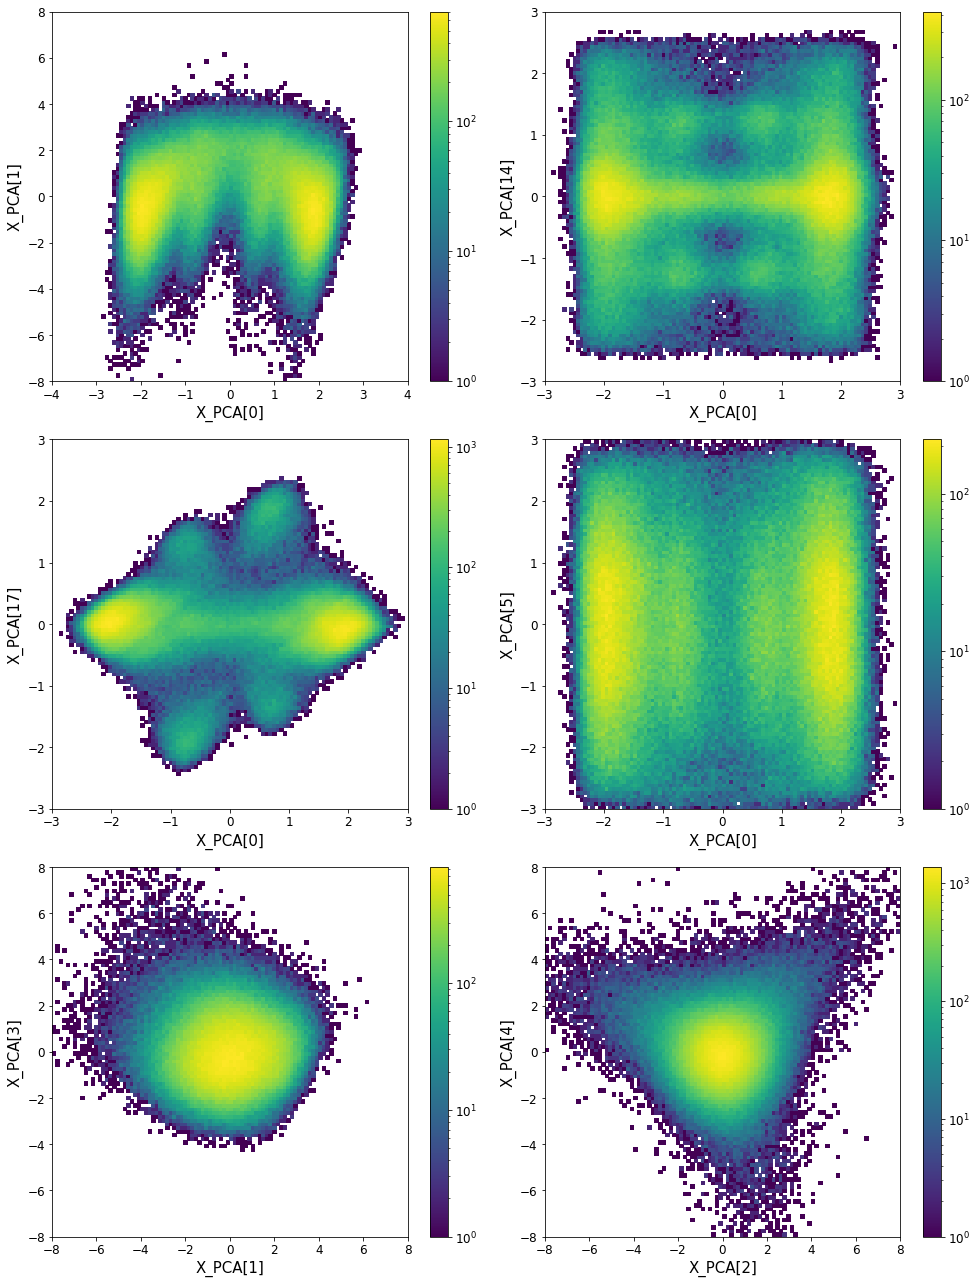

In [53]:
def PCA_ax(ax_pca, i1_pca,i2_pca, Xmax, Ymax, nb):

    counts, xedges, yedges, im = ax_pca.hist2d(X_Train_NN_PCA[:,i1_pca],X_Train_NN_PCA[:,i2_pca], bins=nb, 
                                               range = [[-Xmax, Xmax], [-Ymax, Ymax]], norm=LogNorm(), cmap = 'viridis')
#     counts, xedges, yedges, im = ax_pca.hist2d(X_Train_NN_PCA[:,i1_pca][Y_Train_NN == 0],X_Train_NN_PCA[:,i2_pca][Y_Train_NN==0], 
#                                            bins=nb, range = [[-Xmax, Xmax], [-Ymax, Ymax]], norm=LogNorm(), cmap = 'viridis')    

    plt.colorbar(im, ax=ax_pca)
    ax_pca.set_xlabel('X_PCA['+str(i1_pca)+']')
    ax_pca.set_ylabel('X_PCA['+str(i2_pca)+']')
    return ax_pca

# useful links about SVD:
# https://www.youtube.com/watch?v=P5mlg91as1c
# https://www.youtube.com/watch?v=P5mlg91as1c

# Calculate covariance matrix

X_Conv = np.dot(X_Train_NN.T,X_Train_NN)/X_Train_NN.shape[0]
# X_Conv = np.cov(X_Train_NN.T)
#logger.debug("Covariance matrix X_Conv = " + np.array2string(X_Conv, separator=', ')) # 1/m X^T X

# logger: check that X_train_NN mean and std
mean_X = np.mean(X_Train_NN, axis = 0)
std_X = np.std(X_Train_NN, axis = 0)
logger.debug("mean_X = " + str(mean_X))
logger.debug(" std_X = " + str(std_X))


U, s, vh = np.linalg.svd(X_Conv, full_matrices=True)

# logger.debug("shape of U = " + str(U.shape))
# logger.debug("shape of s = " + str(s.shape))
# logger.debug("shape of vh = " + str(vh.shape))
logger.debug("s = " + str(s))
# # logger.debug("u = " + str(u))

logger.debug("np.linalg.cond(X_Conv) = " + str(np.linalg.cond(X_Conv)))
# logger.debug("checking column orthogonality U.TxU should be 1 = " +str(np.dot(U.T,U)))
logger.debug("checking column orthogonality: np.isclose(np.dot(U.T, U), np.eye(23)).all() = " + str(np.isclose(np.dot(U.T, U), np.eye(23)).all()))

k = 23

U_k = U[:, 0:k]

#convert all data using for Training, Validation, and Y prediction 
X_Train_NN_PCA = X_Train_NN.dot(U_k)
Xnorm_Test_val_PCA = Xnorm_Test_val.dot(U_k)
Xnorm_Train_PCA = Xnorm_Train.dot(U_k)
Xnorm_Test_PCA = Xnorm_Test.dot(U_k)

logger.debug("shape of X_Train_NN_PCA = " + str(X_Train_NN_PCA.shape))
logger.debug("shape of Xnorm_Train_PCA = " + str(Xnorm_Train_PCA.shape))
logger.debug("shape of Xnorm_Test_PCA = " + str(Xnorm_Test_PCA.shape))

# calculated varience retained:
X_approx = X_Train_NN_PCA.dot(U_k.T)
logger.debug("shape of X_approx = " + str(X_approx.shape))

nt = 200
VarOut = np.sum(np.square(X_Train_NN[:nt,:] - X_approx[:nt,:]))/np.sum(np.square(X_Train_NN[:nt,:]))
logger.debug("VarOut on 1st " + str(nt)+ " vertices = " + str(VarOut))
VarRest = np.sum(s[:k])/np.sum(s)
logger.info("Varience retained = " + str(VarRest))

# logger.debug("X_Train_NN[:5,:4] = " +str(X_Train_NN[:5,:4]))
# logger.debug("X_approx[:5,:4] = " +str(X_approx[:5,:4]))

from matplotlib.colors import LogNorm

fig, ((ax, bx),(cx,dx),(ex,fx)) = plt.subplots(3,2, figsize=(14,18))
#fig.delaxes(a_null)

nb = 100
Xmax = 4.

# 0, 14, 17, 19, 21, 22 are interesting
i1_pca = 0
i2_pca = 1
ax = PCA_ax(ax,i1_pca,i2_pca, Xmax, 2*Xmax, nb)

Xmax = 3
i2_pca = 14
bx = PCA_ax(bx,i1_pca,i2_pca, Xmax, Xmax, nb)

i2_pca = 17
cx = PCA_ax(cx,i1_pca,i2_pca, Xmax, Xmax, nb)

#i2_pca = 19
i2_pca = 5
dx = PCA_ax(dx,i1_pca,i2_pca, Xmax, Xmax, nb)

Xmax = 8
i1_pca = 1
i2_pca = 3
ex = PCA_ax(ex,i1_pca,i2_pca, Xmax, Xmax, nb)

i1_pca = 2
i2_pca = 4
fx = PCA_ax(fx,i1_pca,i2_pca, Xmax, Xmax, nb)

fig.tight_layout()
plt.savefig('Results/ControlPlots_Train_PCA_var.pdf')
plt.show()

As you could see from plots above for new variables, X_PCA (X_Train_NN_PCA), extracted from X_Train_NN data, a lot of interesting clusters are observed in 2D plots between different X_PCA variables. 

The rest of variables' pairs in X_PCA looks very similar to X_PCA[1] vs. X_PCA[3] (bottom left plot) and don't have clustering effect.

# Kmeans clustarization algorithm <a class="anchor" id="Kmeans"></a>

Due to some obvious correlations between variables, after PCA, clustering k-mean algorithm could be tried with distortion loss function.

In [22]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=4, n_init=100, random_state=0, batch_size=8192).fit(Xnorm_Train_PCA)

DEBUG:log:kmeans.labels_[0:10] = [1 3 1 2 0 1 0 3 2 2]
DEBUG:log:shape of kmeans.labels_ = (698690,)


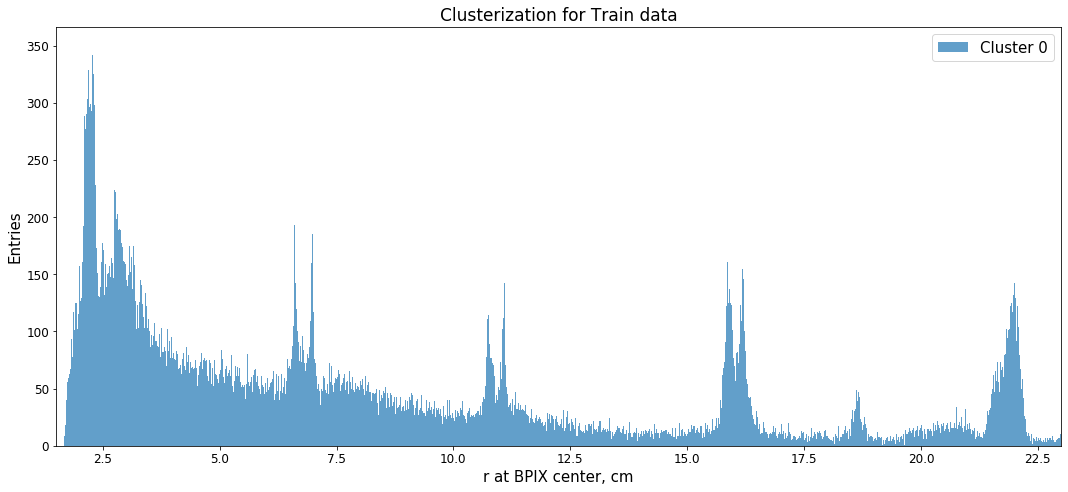

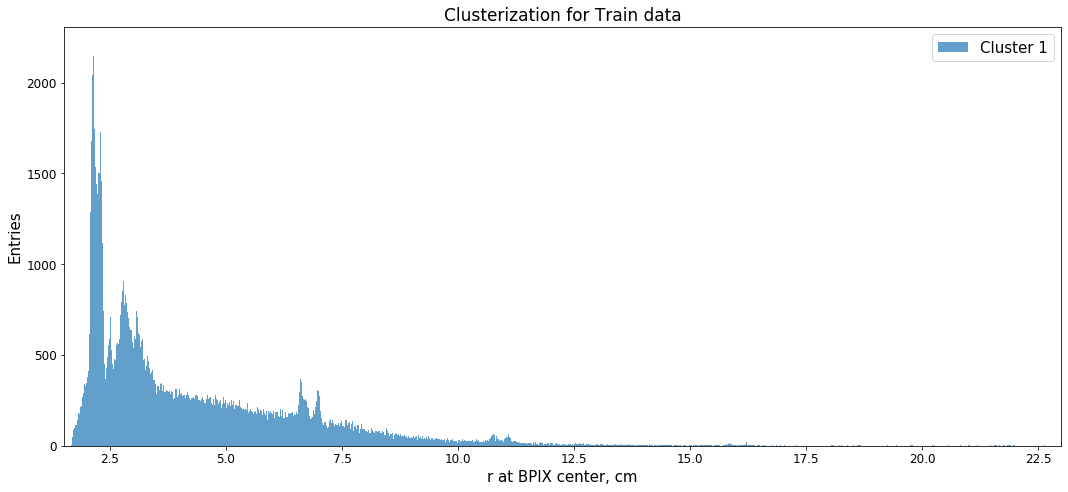

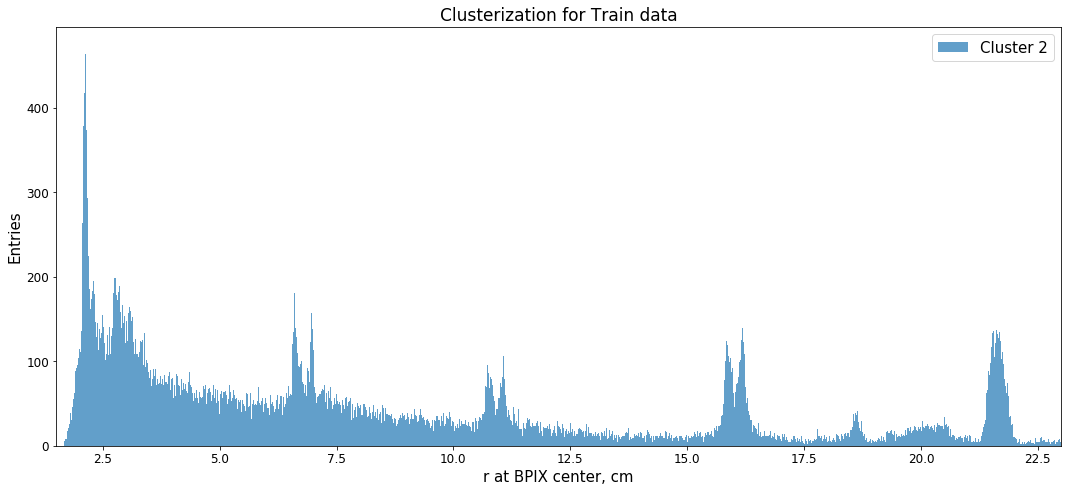

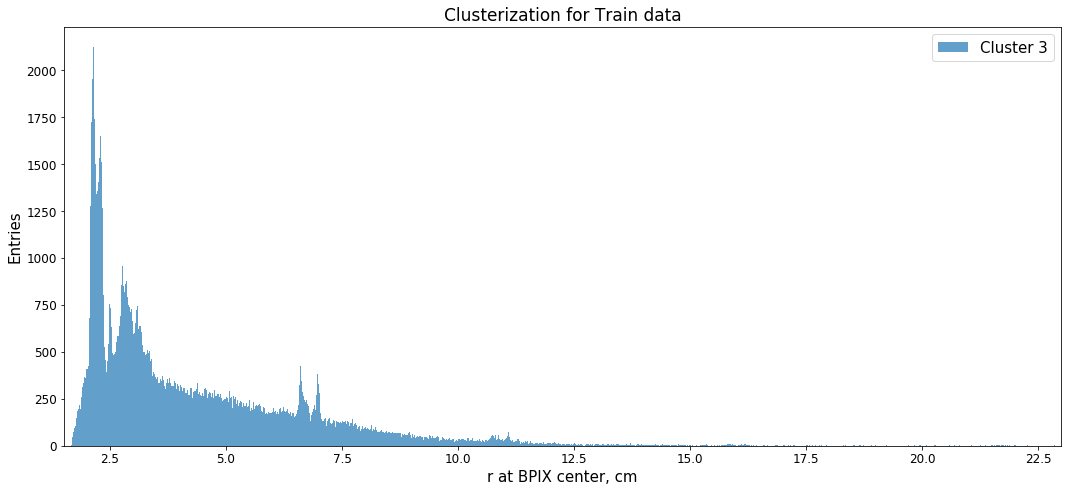

In [23]:
logger.debug("kmeans.labels_[0:10] = " + str(kmeans.labels_[0:10]))
logger.debug("shape of kmeans.labels_ = " + str(kmeans.labels_.shape))
Y_Train_Cluster = kmeans.labels_

#kmeans.predict([[0, 0], [12, 3]])

#kmeans.cluster_centers_

def PlotR_Kmeans_pred(Rad, Y_pred, Rmin, Rmax, Tit, i_cluster, nb):
    # using the variable ax for single a Axes
    fig, ax = plt.subplots(1,1, figsize=(15,7))
    num_bins = nb
    transperance = 0.7
    
    
#     n_Sig, bins, patches = ax.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                   np.logical_and(Y_pred > -1, Y_pred < numSig))], 
#                                num_bins, range =[Rmin,Rmax], alpha = transperance)
    n_Sig, bins, patches = ax.hist(Rad[Y_pred == i_cluster], 
                               num_bins, range =[Rmin,Rmax], alpha = transperance)    
        
    Xtitle = 'r at BPIX center, cm'
    Ytitle = 'Entries'
    ax.set_xlabel(Xtitle)
    ax.set_ylabel(Ytitle)
    ax.set_title("Clusterization for "+ Tit + " data")
    ax.legend(['Cluster ' +str(i_cluster)], loc='upper right')
    ax.set_xlim(Rmin,Rmax)
    
    
    #plt.xscale('log')
    #plt.yscale('log')
    fig.tight_layout()

    #plt.savefig('Results/' + ModelName + '_' + Tit + '_Pred.pdf')
    plt.show()


# the histogram of the data
#Radius_Train = np.sqrt(np.square(data[:,1])+np.square(data[:,2]))
Radius_BP_Train = np.sqrt(np.square(X_Train[:,1]-0.171)+np.square(X_Train[:,2]+0.176))
Radius_BP_Test = np.sqrt(np.square(X_Test[:,1]-0.171)+np.square(X_Test[:,2]+0.176))
Radius_BPIX_Train = np.sqrt(np.square(X_Train[:,1]-0.086)+np.square(X_Train[:,2]+0.102))
Radius_BPIX_Test = np.sqrt(np.square(X_Test[:,1]-0.086)+np.square(X_Test[:,2]+0.102))
Radius_Tube_Train = np.sqrt(np.square(X_Train[:,1]+0.080)+np.square(X_Train[:,2]+0.318))
Radius_Tube_Test = np.sqrt(np.square(X_Test[:,1]+0.080)+np.square(X_Test[:,2]+0.318))

for n_cluster in range(0,4):
    PlotR_Kmeans_pred(Radius_BPIX_Train, Y_Train_Cluster, 1.5, 23., "Train", n_cluster, 2000)

Kmeans clustrating algorithm is not very helpful for the task. Even, if we try to increase numbers of clusters from 4 to 10 or even 20, you still will not achieve signal-backgound separation. So we need NN for the study.

# Keras mode: NN with 2 hidden layers <a class="anchor" id="KerasModel"></a>

Clustering k-mean algorithm could be tried with distortion loss function too.

## Import libraries <a class="anchor" id="ImportKeras"></a>

In [54]:
import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras import regularizers
# to write lost function by yourself:
import keras.backend as K

pythonPath = !echo $PYTHONPATH
#tf.__version__
logger.debug("python path = " + str(pythonPath))
logger.debug("Keras version = " + str(keras.__version__))

# we don't need this utils:
# to use tf_utils, you have to install it in swan terminal:
#pip install --user git+https://github.com/neuroailab/tfutils.git
# it will be installed to /eos/user/k/kropiv/.local/bin
# also see: https://github.com/swan-cern/help/blob/master/advanced/install_packages.md
#from tf_utils import convert_to_one_hot

DEBUG:log:python path = ['/usr/local/lib/swan/extensions/:/cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/python:/cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages']
DEBUG:log:Keras version = 2.2.4


## Create function for NN model with 2 hidden layers <a class="anchor" id="NNfunction"></a>

In [55]:
def NN_2Layers(input_shape, nClasses):


    sentence_indices = Input(shape=input_shape)
    
    RegMode = False
    DropoutMode = False # looks like good for big NN (not our case)
    NumHidLayers = 2 # 1 - default; 2 - non default; 3 + dropout < 0.3 - need more training data
    SigmoidTrue = False # if True then use sigmoid for output level 

    #reg_lambda = 0.5
    reg_lambda = 0.1
    Dropout_frac = 0.3 # which fraction will be dropped
    # 1st layer: Propagate X through a Dense layer with 18 units
    # this layer improve results compare to softmax directly

    #kernel_initializer='he_uniform' for relu  - bad
    #kernel_initializer='he_normal' for relu - similar to default
    
    #define shape of Layer
    #nLayer = aint((sentence_indices.shape[1] + nClasses)/2) # for python 2
    numIn = sentence_indices.shape[1].value
    nLayer = int((numIn + nClasses)/2)
    
    if NumHidLayers > 1: # from 2 hidden layers
#         nLayer = int((2*numIn + nClasses)/3)
#         nLayer = int((numIn + nClasses)/2) # default
        nLayer = int(0.4*(numIn + nClasses)*1.2)# modified
#         if DropoutMode == True:
#             nLayer = int(nLayer/(1-Dropout_frac))# modified -> give more parameters to train if drop
#         nLayer = int(0.33*(numIn + nClasses))# mod1 - bad

    if RegMode == True:
        X = Dense(nLayer, use_bias=False,
                 kernel_regularizer=regularizers.l2(reg_lambda))(sentence_indices)
    else:
        X = Dense(nLayer, use_bias=False)(sentence_indices)
        
    X = BatchNormalization()(X)
    X = Activation("relu")(X)

    # Add dropout with a probability of 0.7
    if DropoutMode == True:
        X = Dropout(Dropout_frac)(X)

    # 2nd hidden layer
    if NumHidLayers > 1:
#         nLayer2 = int((2*nClasses + numIn)/3)
#         nLayer2 = int((nClasses + nLayer)/2)
        nLayer2 = nLayer
#         if DropoutMode == True:
#             nLayer2 = int(nLayer2/(1-Dropout_frac))
        if RegMode == True:
            X = Dense(nLayer2, use_bias=False,
                     kernel_regularizer=regularizers.l2(reg_lambda))(X)
        else:
            X = Dense(nLayer2, use_bias=False)(X)

        X = BatchNormalization()(X)
        X = Activation("relu")(X)
        # Add dropout with a probability of 0.5
        if DropoutMode == True:
            X = Dropout(Dropout_frac)(X)
        
    # 3d hidden layer
    if NumHidLayers > 2:
        nLayer3 = int((nClasses + nLayer2)/2)
        if RegMode == True:
            X = Dense(nLayer3, use_bias=False,
                     kernel_regularizer=regularizers.l2(reg_lambda))(X)
        else:
            X = Dense(nLayer3, use_bias=False)(X)

        X = BatchNormalization()(X)
        X = Activation("relu")(X)
        # Add dropout with a probability of 0.5
        if DropoutMode == True:
            X = Dropout(Dropout_frac)(X)

    # output layer: softmax with nClasses outputs as for Y
    if nClasses > 2 or SigmoidTrue == False:
        if RegMode == True:
            X = Dense(nClasses, activation="softmax",
                     kernel_regularizer=regularizers.l2(reg_lambda),
                     bias_regularizer=regularizers.l2(reg_lambda))(X)
        else:
            X = Dense(nClasses, activation="softmax")(X)
    else:
        if RegMode == True:
            X = Dense(1, activation="sigmoid",
                     kernel_regularizer=regularizers.l2(reg_lambda),
                     bias_regularizer=regularizers.l2(reg_lambda))(X)
        else:
            X = Dense(1, activation="sigmoid")(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[sentence_indices], outputs=X)

    return model


## Creat NN model structure and compile it <a class="anchor" id="ModelCompile"></a>

Define loss funtion, and monitoring parameters as precision, recall, and f1 Score.

In [56]:
# f1 and f1_loss are taken from here: https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# def f1_loss(y_true, y_pred):
    
#     tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
#     tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
#     fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
#     fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

#     p = tp / (tp + fp + K.epsilon())
#     r = tp / (tp + fn + K.epsilon())

#     f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
#     return 1 - K.mean(f1)

# in principle the same
def f1_score_2(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

#### This fix problem for 2 classes of the same value for all metrics, didn't check if it works for n classes
# taken and modified for numClasses from here:    https://github.com/keras-team/keras/issues/5400

def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
#         y_pred = y_pred[:,1:2]
#         y_true = y_true[:,1:2]
        y_pred = y_pred[:,0:numClasses]
        y_true = y_true[:,0:numClasses]
#         y_pred = y_pred[:,0:1] # train loss only on the Signal region
#         y_true = y_true[:,0:1] # train loss only on the Signal region
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_loss(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = f1*r # correct to f1_loss more weithg for recall
#     f1 = f1*K.sqrt(r) # correct to f1_loss more weithg for recall
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)
#     return K.abs(0.89 - K.mean(f1)) # f1 score injected to NN counting on the labels
#     return K.abs(0.82 - K.mean(f1)) # f1 score injected to NN counting on the labels without BP
#     return K.abs(0.68 - K.mean(f1)) # f1 score injected to NN counting on the labels keep L2 only

### end for test

#reset layers counting
K.clear_session()

model = NN_2Layers((X_Train_NN_PCA.shape[1],),numClasses)

# problem with same outout form metrisc discussed here: https://github.com/keras-team/keras/issues/5400
# looks like if you have 2 classes and use sigmoid instead of softmax doesn't help...
# check_units (see above) hepls to fix problem for 2 classes, didn't check if it works for n classes

# sgd is good for shalow NN (our case), adam is good for deep NN
sgd      = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# default beta_1 = 0.9
adamCorr = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False) # av. by last 100

# default for f1_loss:
# model.compile(loss=f1_loss, optimizer=adamCorr, metrics=['accuracy', f1_score, precision, recall])
# default for categorical_crossentropy loss:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score, precision, recall])

# model.compile(loss=f1_loss, optimizer='Nadam', metrics=['accuracy', f1_score, precision, recall])
# model.compile(loss=f1_loss, optimizer='adam', metrics=['accuracy', f1_score, precision, recall])
# model.compile(loss=f1_loss, optimizer=sgd, metrics=['accuracy', f1_score, precision, recall])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                276       
_________________________________________________________________
batch_normalization_1 (Batch (None, 12)                48        
_________________________________________________________________
activation_1 (Activation)    (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                144       
_________________________________________________________________
batch_normalization_2 (Batch (None, 12)                48        
_________________________________________________________________
activation_2 (Activation)    (None, 12)                0         
__________

## NN model training <a class="anchor" id="ModelTraining"></a>
Skip this section if you are going to upload existing model.

Use only classified events (Signal or Backgound resions only, skip Unclassified resion) for Train set and Validation (Test) set during model model.

In [32]:
def generate_sample_weights(training_data, class_weight_dictionary): 
    sample_weights = [class_weight_dictionary[np.where(one_hot_row==1)[0][0]] for one_hot_row in training_data]
    return np.asarray(sample_weights) # correct on dropout


# not bad:
#class_weight = {0: 2., 1: 2., 2: 3., 3: 3., 4: 4., 5: 4., 6:2., 
#               7:1., 8: 1., 9: 1., 10: 1., 11: 1.}

if numSig == 7:
    class_weight = {0: 10., 1: 0.1, 2: 0.1, 3: 10., 4: 5., 5: 5., 6:4., 
                   7:1., 8: 1., 9: 1., 10: 1., 11: 1.}
if numSig == 4:
    #               BP      L2     L3    L4, OS, Rails, Tube     BKG
    class_weight = {0: 4.2, 1: 9., 2: 12., 3: 2.,                  4: 1.} # for ...Epoch1000_L2L3 tune final
#     class_weight = {0: 3.9, 1: 10., 2: 14., 3: 2.,                  4: 1.} # for ...Epoch1000_L2L3 NN 3 layers
#     class_weight = {0: 2., 1: 7., 2: 10., 3: 2.,                  4: 1.} # for ...low pile up

if numSig == 1:
    #               BP,L2-L4, OS, Rails, Tube     BKG
     class_weight = {0: 3.,                    1: 1.} 
#     class_weight = {0: 3.4,                    1: 1.} # if remove S6 (OS, Rails, Tube)
    
#train and keep history about model:
history = model.fit(X_Train_NN_PCA, Y_Train_NN_hot, epochs = 300, 
                    validation_data=(Xnorm_Test_val_PCA, Y_Test_val_hot,
                                     generate_sample_weights(Y_Test_val_hot, class_weight)),
                    batch_size = 8192, shuffle=True, class_weight=class_weight)

# no weights for customized models:
# usually you need 300-500 epochs to train model well, but we set it to 50 for fast results
# history = model.fit(X_Train_NN_PCA, Y_Train_NN_hot, epochs = 100, validation_data=(Xnorm_Test_val_PCA, Y_Test_val_hot),
#                     batch_size = batchSize, shuffle=True)

Train on 415289 samples, validate on 414198 samples
Epoch 1/300
415289/415289 [==============================] - 2s 4us/step - loss: 1.1092 - acc: 0.5180 - f1_score: 0.5180 - precision: 0.5180 - recall: 0.5180 - val_loss: 1.0578 - val_acc: 0.4810 - val_f1_score: 0.4810 - val_precision: 0.4810 - val_recall: 0.4810
Epoch 2/300
415289/415289 [==============================] - 1s 3us/step - loss: 1.0297 - acc: 0.5285 - f1_score: 0.5285 - precision: 0.5285 - recall: 0.5285 - val_loss: 1.0128 - val_acc: 0.5400 - val_f1_score: 0.5400 - val_precision: 0.5400 - val_recall: 0.5400
Epoch 3/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.9925 - acc: 0.5736 - f1_score: 0.5736 - precision: 0.5736 - recall: 0.5736 - val_loss: 0.9806 - val_acc: 0.5793 - val_f1_score: 0.5793 - val_precision: 0.5793 - val_recall: 0.5793
Epoch 4/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.9634 - acc: 0.6138 - f1_score: 0.6138 - precision: 0.6138 - recall: 0.6138 -

Epoch 32/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.8141 - acc: 0.7424 - f1_score: 0.7424 - precision: 0.7424 - recall: 0.7424 - val_loss: 0.8198 - val_acc: 0.7533 - val_f1_score: 0.7533 - val_precision: 0.7533 - val_recall: 0.7533
Epoch 33/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.8124 - acc: 0.7422 - f1_score: 0.7422 - precision: 0.7422 - recall: 0.7422 - val_loss: 0.8179 - val_acc: 0.7532 - val_f1_score: 0.7532 - val_precision: 0.7532 - val_recall: 0.7532
Epoch 34/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.8110 - acc: 0.7436 - f1_score: 0.7436 - precision: 0.7436 - recall: 0.7436 - val_loss: 0.8174 - val_acc: 0.7556 - val_f1_score: 0.7556 - val_precision: 0.7556 - val_recall: 0.7556
Epoch 35/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.8097 - acc: 0.7432 - f1_score: 0.7432 - precision: 0.7432 - recall: 0.7432 - val_loss: 0.8156 - val_acc: 0.7551 - val_f1_sco

415289/415289 [==============================] - 1s 2us/step - loss: 0.7953 - acc: 0.7541 - f1_score: 0.7541 - precision: 0.7541 - recall: 0.7541 - val_loss: 0.8005 - val_acc: 0.7607 - val_f1_score: 0.7607 - val_precision: 0.7607 - val_recall: 0.7607
Epoch 64/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7951 - acc: 0.7546 - f1_score: 0.7546 - precision: 0.7546 - recall: 0.7546 - val_loss: 0.8004 - val_acc: 0.7562 - val_f1_score: 0.7562 - val_precision: 0.7562 - val_recall: 0.7562
Epoch 65/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7948 - acc: 0.7542 - f1_score: 0.7542 - precision: 0.7542 - recall: 0.7542 - val_loss: 0.8001 - val_acc: 0.7583 - val_f1_score: 0.7583 - val_precision: 0.7583 - val_recall: 0.7583
Epoch 66/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7947 - acc: 0.7548 - f1_score: 0.7548 - precision: 0.7548 - recall: 0.7548 - val_loss: 0.7996 - val_acc: 0.7594 - val_f1_score: 0.7594 - 

415289/415289 [==============================] - 1s 2us/step - loss: 0.7907 - acc: 0.7581 - f1_score: 0.7581 - precision: 0.7581 - recall: 0.7581 - val_loss: 0.7956 - val_acc: 0.7558 - val_f1_score: 0.7558 - val_precision: 0.7558 - val_recall: 0.7558
Epoch 95/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7906 - acc: 0.7592 - f1_score: 0.7592 - precision: 0.7592 - recall: 0.7592 - val_loss: 0.7958 - val_acc: 0.7557 - val_f1_score: 0.7557 - val_precision: 0.7557 - val_recall: 0.7557
Epoch 96/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7907 - acc: 0.7579 - f1_score: 0.7579 - precision: 0.7579 - recall: 0.7579 - val_loss: 0.7956 - val_acc: 0.7594 - val_f1_score: 0.7594 - val_precision: 0.7594 - val_recall: 0.7594
Epoch 97/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7904 - acc: 0.7581 - f1_score: 0.7581 - precision: 0.7581 - recall: 0.7581 - val_loss: 0.7955 - val_acc: 0.7586 - val_f1_score: 0.7586 - 

Epoch 125/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7886 - acc: 0.7596 - f1_score: 0.7596 - precision: 0.7596 - recall: 0.7596 - val_loss: 0.7935 - val_acc: 0.7581 - val_f1_score: 0.7581 - val_precision: 0.7581 - val_recall: 0.7581
Epoch 126/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7887 - acc: 0.7595 - f1_score: 0.7595 - precision: 0.7595 - recall: 0.7595 - val_loss: 0.7938 - val_acc: 0.7632 - val_f1_score: 0.7632 - val_precision: 0.7632 - val_recall: 0.7632
Epoch 127/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7885 - acc: 0.7599 - f1_score: 0.7599 - precision: 0.7599 - recall: 0.7599 - val_loss: 0.7937 - val_acc: 0.7564 - val_f1_score: 0.7564 - val_precision: 0.7564 - val_recall: 0.7564
Epoch 128/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7887 - acc: 0.7604 - f1_score: 0.7604 - precision: 0.7604 - recall: 0.7604 - val_loss: 0.7938 - val_acc: 0.7550 - val_f1

Epoch 156/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7869 - acc: 0.7612 - f1_score: 0.7612 - precision: 0.7612 - recall: 0.7612 - val_loss: 0.7917 - val_acc: 0.7602 - val_f1_score: 0.7602 - val_precision: 0.7602 - val_recall: 0.7602
Epoch 157/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7868 - acc: 0.7605 - f1_score: 0.7605 - precision: 0.7605 - recall: 0.7605 - val_loss: 0.7920 - val_acc: 0.7596 - val_f1_score: 0.7596 - val_precision: 0.7596 - val_recall: 0.7596
Epoch 158/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7865 - acc: 0.7618 - f1_score: 0.7618 - precision: 0.7618 - recall: 0.7618 - val_loss: 0.7919 - val_acc: 0.7575 - val_f1_score: 0.7575 - val_precision: 0.7575 - val_recall: 0.7575
Epoch 159/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7866 - acc: 0.7613 - f1_score: 0.7613 - precision: 0.7613 - recall: 0.7613 - val_loss: 0.7921 - val_acc: 0.7596 - val_f1

Epoch 187/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7854 - acc: 0.7614 - f1_score: 0.7614 - precision: 0.7614 - recall: 0.7614 - val_loss: 0.7904 - val_acc: 0.7627 - val_f1_score: 0.7627 - val_precision: 0.7627 - val_recall: 0.7627
Epoch 188/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7854 - acc: 0.7622 - f1_score: 0.7622 - precision: 0.7622 - recall: 0.7622 - val_loss: 0.7904 - val_acc: 0.7626 - val_f1_score: 0.7626 - val_precision: 0.7626 - val_recall: 0.7626
Epoch 189/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7852 - acc: 0.7617 - f1_score: 0.7617 - precision: 0.7617 - recall: 0.7617 - val_loss: 0.7906 - val_acc: 0.7611 - val_f1_score: 0.7611 - val_precision: 0.7611 - val_recall: 0.7611
Epoch 190/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7853 - acc: 0.7617 - f1_score: 0.7617 - precision: 0.7617 - recall: 0.7617 - val_loss: 0.7907 - val_acc: 0.7581 - val_f1

Epoch 218/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7845 - acc: 0.7628 - f1_score: 0.7628 - precision: 0.7628 - recall: 0.7628 - val_loss: 0.7896 - val_acc: 0.7635 - val_f1_score: 0.7635 - val_precision: 0.7635 - val_recall: 0.7635
Epoch 219/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7846 - acc: 0.7629 - f1_score: 0.7629 - precision: 0.7629 - recall: 0.7629 - val_loss: 0.7901 - val_acc: 0.7630 - val_f1_score: 0.7630 - val_precision: 0.7630 - val_recall: 0.7630
Epoch 220/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7844 - acc: 0.7632 - f1_score: 0.7632 - precision: 0.7632 - recall: 0.7632 - val_loss: 0.7898 - val_acc: 0.7581 - val_f1_score: 0.7581 - val_precision: 0.7581 - val_recall: 0.7581
Epoch 221/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7846 - acc: 0.7632 - f1_score: 0.7632 - precision: 0.7632 - recall: 0.7632 - val_loss: 0.7902 - val_acc: 0.7592 - val_f1

Epoch 249/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7837 - acc: 0.7646 - f1_score: 0.7646 - precision: 0.7646 - recall: 0.7646 - val_loss: 0.7884 - val_acc: 0.7647 - val_f1_score: 0.7647 - val_precision: 0.7647 - val_recall: 0.7647
Epoch 250/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7837 - acc: 0.7645 - f1_score: 0.7645 - precision: 0.7645 - recall: 0.7645 - val_loss: 0.7883 - val_acc: 0.7625 - val_f1_score: 0.7625 - val_precision: 0.7625 - val_recall: 0.7625
Epoch 251/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7840 - acc: 0.7634 - f1_score: 0.7634 - precision: 0.7634 - recall: 0.7634 - val_loss: 0.7882 - val_acc: 0.7623 - val_f1_score: 0.7623 - val_precision: 0.7623 - val_recall: 0.7623
Epoch 252/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7835 - acc: 0.7638 - f1_score: 0.7638 - precision: 0.7638 - recall: 0.7638 - val_loss: 0.7884 - val_acc: 0.7624 - val_f1

Epoch 280/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7829 - acc: 0.7638 - f1_score: 0.7638 - precision: 0.7638 - recall: 0.7638 - val_loss: 0.7877 - val_acc: 0.7629 - val_f1_score: 0.7629 - val_precision: 0.7629 - val_recall: 0.7629
Epoch 281/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7830 - acc: 0.7637 - f1_score: 0.7637 - precision: 0.7637 - recall: 0.7637 - val_loss: 0.7872 - val_acc: 0.7621 - val_f1_score: 0.7621 - val_precision: 0.7621 - val_recall: 0.7621
Epoch 282/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7827 - acc: 0.7645 - f1_score: 0.7645 - precision: 0.7645 - recall: 0.7645 - val_loss: 0.7875 - val_acc: 0.7667 - val_f1_score: 0.7667 - val_precision: 0.7667 - val_recall: 0.7667
Epoch 283/300
415289/415289 [==============================] - 1s 2us/step - loss: 0.7826 - acc: 0.7643 - f1_score: 0.7643 - precision: 0.7643 - recall: 0.7643 - val_loss: 0.7879 - val_acc: 0.7677 - val_f1

## Save/Load NN model to/from file <a class="anchor" id="Save-Load-Model"></a>

In [57]:
import json
from keras.models import load_model

SaveMode = False
LoadMode = True

# lr = 0.1, too large, not train model, even 0.02 is bad too
# default model
ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_CrossEntropy_f1loss_batchSize8192_adamLr0p005_PCA23' # 300 Ephoch

# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_CrossEntropy_f1loss_batchSize8192_adamLr0p005_PCA23_Epoch300'
# ModelName = 'model_Sig1_noIS_noL1_noS6_Bkg1_2HLmod_CrossEntropy_f1loss_batchSize8192_adamLr0p005_PCA23'

# two models from Tracker Workshop 05 May 2020
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1loss_batchSize8192_adamLr0p005_Epoch500'
# ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_f1lossCorrR_batchSize8192_adamLr0p005_Epoch500'


FileModelName = 'TrainedModels/' + ModelName

if SaveMode:
    #save model:
    model.save(FileModelName + '.h5')
    # save history:
    with open(FileModelName + '.json', 'w') as f:
        json.dump(history.history, f)

    # plot model only in SaveMode
    # python 3.4 and about only for redirect_stdout
    from contextlib import redirect_stdout
    NameSum = 'Results/' + ModelName + '_summary.txt'
    with open(NameSum, 'w') as f:
        with redirect_stdout(f):
            model.summary()
    # plot model:
    from keras.utils import plot_model
    plot_model(model, to_file = 'Results/' + ModelName + '.pdf',show_shapes = True)

# del model
# del history

FileLoadName = 'TrainedModels/' + ModelName

# returns a compiled and trained model
# if loss == f1_loss
f1lossMode = "f1loss" in ModelName
if LoadMode : 
    if f1lossMode:
        model_X = load_model(FileLoadName + '.h5', 
                             custom_objects={'f1_loss':f1_loss, 'f1_score':f1_score, 
                                             'precision':precision, 'recall':recall})
        history_X = json.load(open(FileLoadName + '.json', 'r'))
    else:
        model_X = load_model(FileLoadName + '.h5', custom_objects={'f1_score':f1_score, 'precision':precision, 'recall':recall})
        history_X = json.load(open(FileLoadName + '.json', 'r'))

if LoadMode == False:
    model_X = model
    history_X = history.history

## Monitor performance during training <a class="anchor" id="MonitorTraining"></a>

Monitor accuracy, precision, recall, f1 Score, and loss function.

dict_keys(['val_loss', 'val_acc', 'val_f1_score', 'val_precision', 'val_recall', 'loss', 'acc', 'f1_score', 'precision', 'recall'])
shape acc = (300,)


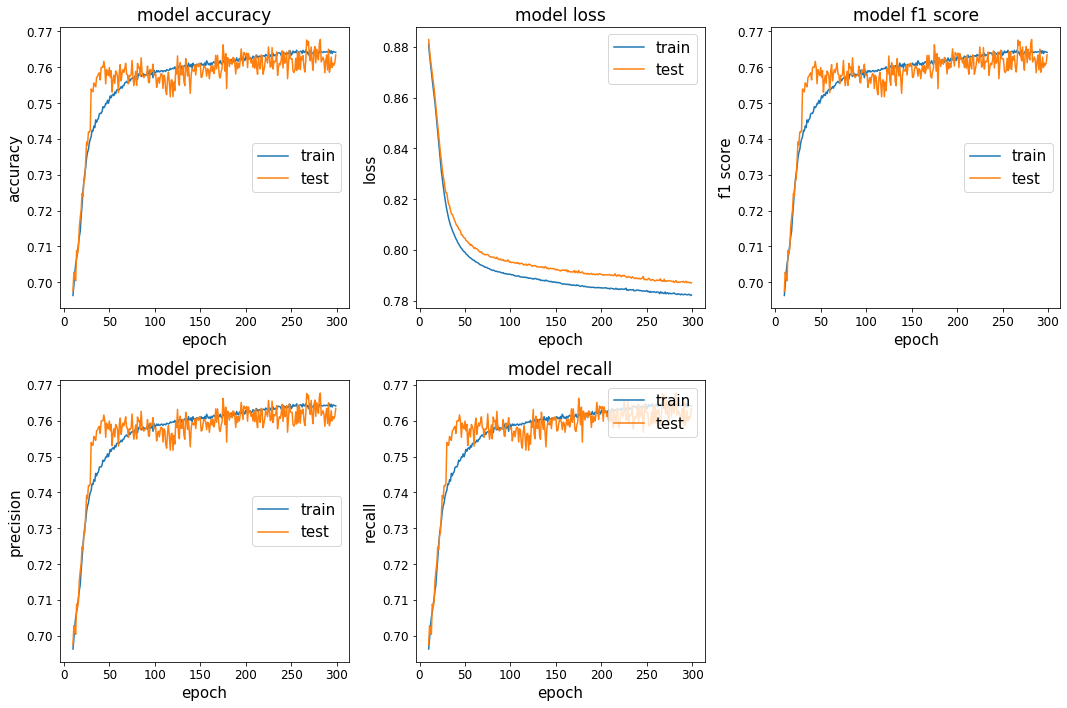

In [58]:
#plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize = 15)
plt.rc('axes', titlesize= 17)
plt.rc('font', size=12) 
plt.rc('legend', fontsize=15) 
# list all data in history
# print(history.history.keys())
print(history_X.keys())
# summarize history for accuracy

# set epoch range
par_acc = np.array(history_X['acc'])
print("shape acc = " + str(par_acc.shape))
par_val_acc = np.array(history_X['val_acc'])
par_loss = np.array(history_X['loss'])
par_val_loss = np.array(history_X['val_loss'])
par_f1_score = np.array(history_X['f1_score'])
par_val_f1_score = np.array(history_X['val_f1_score'])
par_precision = np.array(history_X['precision'])
par_val_precision = np.array(history_X['val_precision'])
par_recall = np.array(history_X['recall'])
par_val_recall = np.array(history_X['val_recall'])

nEpoch_min = 10
nEpoch_max = par_acc.shape[0]
xc         = range(nEpoch_min,nEpoch_max)


# need to be 2D with shape (2,2) if (2,2) plots 
fig, ((a_acc, a_loss, a_f1), (a_prec, a_recall, a_null)) = plt.subplots(2,3,  figsize=(15,10))
fig.delaxes(a_null)
#fig.delaxes(a_f1)
    
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
a_acc.plot(xc,par_acc[nEpoch_min:nEpoch_max])
a_acc.plot(xc,par_val_acc[nEpoch_min:nEpoch_max])
a_acc.set_title('model accuracy')
a_acc.set_ylabel('accuracy')
a_acc.set_xlabel('epoch')
a_acc.legend(['train', 'test'], loc='center right')
#a_acc.set_xlim(nEpoch_min,nEpoch_max)

# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
a_loss.plot(xc,par_loss[nEpoch_min:nEpoch_max])
a_loss.plot(xc,par_val_loss[nEpoch_min:nEpoch_max])
a_loss.set_title('model loss')
a_loss.set_ylabel('loss')
a_loss.set_xlabel('epoch')
a_loss.legend(['train', 'test'], loc='upper right')

a_f1.plot(xc,par_f1_score[nEpoch_min:nEpoch_max])
a_f1.plot(xc,par_val_f1_score[nEpoch_min:nEpoch_max])
a_f1.set_title('model f1 score')
a_f1.set_ylabel('f1 score')
a_f1.set_xlabel('epoch')
a_f1.legend(['train', 'test'], loc='center right')

a_prec.plot(xc,par_precision[nEpoch_min:nEpoch_max])
a_prec.plot(xc,par_val_precision[nEpoch_min:nEpoch_max])
a_prec.set_title('model precision')
a_prec.set_ylabel('precision')
a_prec.set_xlabel('epoch')
a_prec.legend(['train', 'test'], loc='center right')

a_recall.plot(xc,par_recall[nEpoch_min:nEpoch_max])
a_recall.plot(xc,par_val_recall[nEpoch_min:nEpoch_max])
a_recall.set_title('model recall')
a_recall.set_ylabel('recall')
a_recall.set_xlabel('epoch')
a_recall.legend(['train', 'test'], loc='upper right')

fig.tight_layout()
#fig.tight_layout(pad=1.0)
plt.savefig('Results/' + ModelName + '_history.pdf')
plt.show()

## Model Results <a class="anchor" id="ModelResults"></a>
Use all events (Signal, Backgound, and Unclassified regions) for Train and Test sets.

### Predict Y for Train and Test sets <a class="anchor" id="PredictY"></a>
Prediction is done for all regions for the data set, inlcuding unclassified region.

In [59]:
Y_hot_Test_pred = model_X.predict(Xnorm_Test_PCA)
Y_hot_Train_pred = model_X.predict(Xnorm_Train_PCA)

# Y_hot_Test_pred = model_X.predict(Xnorm_Test)
# Y_hot_Train_pred = model_X.predict(Xnorm_Train)

### Plot Y prediction of Test set for n-th class <a class="anchor" id="PlotY"></a>

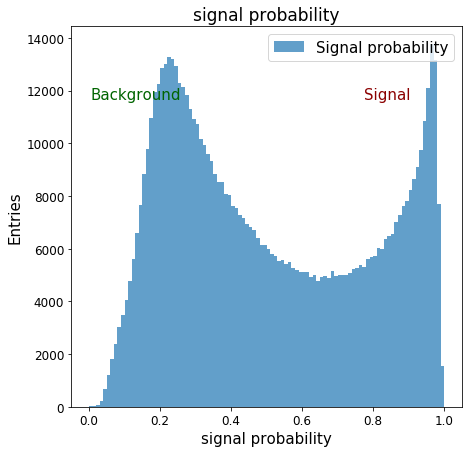

In [62]:
# Signal class:
nclass = 0

Y_Test_pred_nclass = Y_hot_Test_pred[:,nclass]
# fig, (ax,bx) = plt.subplots(1,2, figsize=(15,7))
fig, (ax) = plt.subplots(1,1, figsize=(7,7))
num_bins = 100
transperance = 0.7

n, bins, patches = ax.hist(Y_Test_pred_nclass, 
                            num_bins, range =[0,1], alpha = transperance)
# n, bins, patches = bx.hist(Y_Test_pred_nclass, 
#                             num_bins, range =[1.0e-3,1-1.0e-3], alpha = transperance)
Xtitle = 'signal probability'
Ytitle = 'Entries'
ax.set_xlabel(Xtitle)
ax.set_ylabel(Ytitle)
ax.set_title(Xtitle)
ax.legend(['Signal probability'], loc='upper right')
# x_B, y_B = 0.1, 0.8
# x_S, y_S = 0.75, 0.5
x_B, y_B = 0.05, 0.8
x_S, y_S = 0.75, 0.8
ax.text(x_B, y_B, "Background",
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes, color='darkgreen', fontsize=15)
ax.text(x_S, y_S, "Signal",
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes, color='darkred', fontsize=15)

# bx.text(0.1, 0.8, "Background",
#         verticalalignment='bottom', horizontalalignment='left',
#         transform=bx.transAxes, color='darkgreen', fontsize=15)
# bx.text(0.75, 0.75, "Signal",
#         verticalalignment='bottom', horizontalalignment='left',
#         transform=bx.transAxes, color='darkred', fontsize=15)

# Xtitle = 'signal probability from $10^{-3}$ to $1-10^{-3}$'
# bx.set_xlabel(Xtitle)
# bx.set_ylabel(Ytitle)
# bx.set_title(Xtitle)
# bx.legend(['Signal probability'], loc='upper right')

#plt.xscale('log')

plt.savefig('Results/' + ModelName +'_SignalProbability.pdf')
plt.show()

### Set threshold for Signal-Background seperation <a class="anchor" id="SetYthreshold"></a>

Default threshold is cutHot = 0.5 is recommended to use.

In [64]:
def YpredCut(Y_hot_pred, cutHot):

    if numSig == 1:
        Y_pred = Y_hot_pred[:,0] # signal probability
        Y_pred = 1.*np.invert(Y_pred > cutHot)
    else:
        Y_pred = np.argmax(Y_hot_pred, axis = 1)

    #logger.info("shape of Y_Test_pred = " + str(Y_Test_pred.shape))

    # argsort_Y_hot_Test = np.argsort(Y_hot_Test_pred, axis = 1)
    # argsort_Y_hot_Train = np.argsort(Y_hot_Train_pred, axis = 1)
    return Y_pred

cutHotPred  = 0.5
Y_Test_pred = YpredCut(Y_hot_Test_pred, cutHotPred)
Y_Train_pred = YpredCut(Y_hot_Train_pred, cutHotPred)

#for categorical_crossentropy, could make scane from 0.35 to 0.6

### Optimize Predictions with Maximizing f1 Score for Real Signal-Background  <a class="anchor" id="YpredOptimization"></a>

Y prediction optimization should be done on the Validation Set, but due to lake of data, we are useing Train Set for optimization.

$Y_{Pred}$ is selected such way to maximize 

$f1 score = 2\times(precision\times recall)/(precision + recall)$

between real NIs and combinatorial background, which requires high precision (purity) and high recall (efficiency) at the same time!

Real $S_{estimate}$ and $B_{estimate}$ are estimated from signal and background predictions respectively:


    p = tp / (tp + fp)
    r = tp / (tp + fn)

    f1 = 2*p*r / (p+r)
    


DEBUG:log:S_est_forB = [6582.         1144.3         451.2         859.5         968.3
  288.08333333]
DEBUG:log:S_est_forB = [6572.6  1143.2   449.3   860.5   968.5   288.15]
DEBUG:log:S_est_forB = [6565.7  1146.3   446.9   860.3   968.4   287.85]
DEBUG:log:S_est_forB = [6558.9        1141.7         443.2         859.1         968.4
  288.23333333]
DEBUG:log:S_est_forB = [6545.3        1137.9         439.7         858.2         968.7
  288.63333333]
DEBUG:log:S_est_forB = [6529.2  1130.2   438.6   858.6   968.8   288.95]
DEBUG:log:S_est_forB = [6514.9 1123.7  435.1  858.   968.9  288.9]
DEBUG:log:S_est_forB = [6503.2  1116.    433.9   857.    968.4   288.75]
DEBUG:log:S_est_forB = [6489.1  1109.7   430.2   855.6   968.4   288.25]
DEBUG:log:S_est_forB = [6470.3        1103.7         429.          854.3         968.1
  288.11666667]
DEBUG:log:S_est_forB = [6451.5        1095.3         425.1         852.9         967.9
  287.88333333]
DEBUG:log:S_est_forB = [6430.3        1084.6         

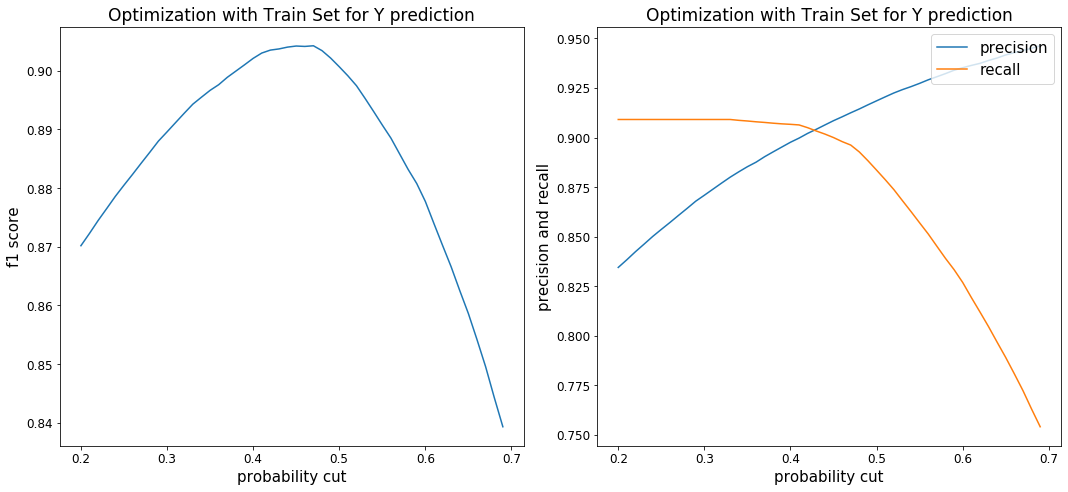

In [139]:
# Radius for different structures:
Radius_BP_Train = np.sqrt(np.square(X_Train[:,1]-0.171)+np.square(X_Train[:,2]+0.176))
Radius_BPIX_Train = np.sqrt(np.square(X_Train[:,1]-0.086)+np.square(X_Train[:,2]+0.102))
Radius_Tube_Train = np.sqrt(np.square(X_Train[:,1]+0.080)+np.square(X_Train[:,2]+0.318))

Radius_BPIX_Test = np.sqrt(np.square(X_Test[:,1]-0.086)+np.square(X_Test[:,2]+0.102))
Radius_BP_Test = np.sqrt(np.square(X_Test[:,1]-0.171)+np.square(X_Test[:,2]+0.176))
Radius_Tube_Test = np.sqrt(np.square(X_Test[:,1]+0.080)+np.square(X_Test[:,2]+0.318))

# only Train Set is using for optimization:
MaterialforOptimization = ["BP", "L2", "L3", "L4", "Tube", "Rails"]
def f1score_Ypred (Mat, Y_pred, Rad_BP, Rad_BPIX, Rad_Tube, X_Rails):

    # [1] for S estimate, [2] for B_estimate
    S_est_forS, B_est_forS = PreReF1(Rad_BP[Y_pred==0], Rad_BPIX[Y_pred ==0], Rad_Tube[Y_pred ==0], 
                         X_Rails[Y_pred ==0], Mat, MaterialOfPixel)[1:3]
    S_est_forB, B_est_forB = PreReF1(Rad_BP[Y_pred==1], Rad_BPIX[Y_pred ==1], Rad_Tube[Y_pred ==1], 
                         X_Rails[Y_pred ==1], Mat, MaterialOfPixel)[1:3]

    epsilon = 1.0e-6

    # for background classification, signal estimation could be < 0, so make reset to 0 
    # to not confuse calculations, in future better signal estimation should be perform
    scut = 0.10
#     S_est_forB[S_est_forB < scut*B_est_forB] = scut*B_est_forB[S_est_forB < scut*B_est_forB]
#     S_est_forB[S_est_forB < 0] = 0
    S_est_forB[S_est_forB < scut*S_est_forS] = scut*S_est_forS[S_est_forB < scut*S_est_forS]
    logger.debug("S_est_forB = " +str(S_est_forB))

    
    tp = np.sum(S_est_forS) # Signal, classified as Signal
    fp = np.sum(B_est_forS) # Background, classified as Signal
    fn = np.sum(S_est_forB) # Signal, classified s Background

    prec_Mat = tp / (tp + fp + epsilon)
    recall_Mat = tp / (tp + fn + epsilon)

    f1_Mat = 2*prec_Mat*recall_Mat / (prec_Mat+recall_Mat+epsilon)

    #logger.info("Optimized material: precison = %3.3f, recall =  %3.2f, f1 score =  %3.2f" % (prec_Mat, recall_Mat, f1_Mat))
    
    return f1_Mat, prec_Mat, recall_Mat


ymin = 0.2
ymax = 0.7
n_frac = 50
CutSel       = np.zeros(n_frac) 
f1ScoreOpt   = np.zeros(n_frac)
precisionOpt = np.zeros(n_frac)
recallOpt    = np.zeros(n_frac)

f1ScoreMax = -1.
recallMax = -1
CutSel_Opt = -1.


for i in range(0,n_frac):
    CutSel[i] = ymin +i*(ymax-ymin)/n_frac
    Y_Train_pred_Cut = YpredCut(Y_hot_Train_pred, CutSel[i])
    f1ScoreOpt[i], precisionOpt[i], recallOpt[i] = f1score_Ypred (MaterialforOptimization, Y_Train_pred_Cut, 
                                                                  Radius_BP_Train, Radius_BPIX_Train, 
                                                                  Radius_Tube_Train, X_Train[:,1])
    if f1ScoreOpt[i] > f1ScoreMax:
        f1ScoreMax = f1ScoreOpt[i]
        CutSel_Opt = CutSel[i]
        recallMax  = recallOpt[i]

# assign predictions for Train and Test sets with optimal cut:
Y_Train_pred = YpredCut(Y_hot_Train_pred, CutSel_Opt)
Y_Test_pred = YpredCut(Y_hot_Test_pred, CutSel_Opt)

logger.debug("Optimized material: f1score opt = " +str(f1ScoreOpt))
logger.info("Optimized values: CutSel = %3.2f, f1 score = %3.2f, and recall = %3.2f" %
            (CutSel_Opt, f1ScoreMax, recallMax))

fig, (ax,bx) = plt.subplots(1,2,  figsize=(15,7))

ax.plot(CutSel,f1ScoreOpt)
ax.set_title('Optimization with Train Set for Y prediction')
ax.set_ylabel('f1 score')
ax.set_xlabel('probability cut')
#ax.legend(['train', 'test'], loc='upper right')

bx.plot(CutSel,precisionOpt)
bx.plot(CutSel,recallOpt)
bx.set_title('Optimization with Train Set for Y prediction')
bx.set_ylabel('precision and recall')
bx.set_xlabel('probability cut')
bx.legend(['precision', 'recall'], loc='upper right')

fig.tight_layout()
#fig.tight_layout(pad=1.0)
plt.savefig('Results/' + ModelName + '_Yoptimization.pdf')
plt.show()


### Plot Train and Test prediction for Signal-Background seperation as function of  BPIX radius <a class="anchor" id="PlotPredictedResultsR"></a>

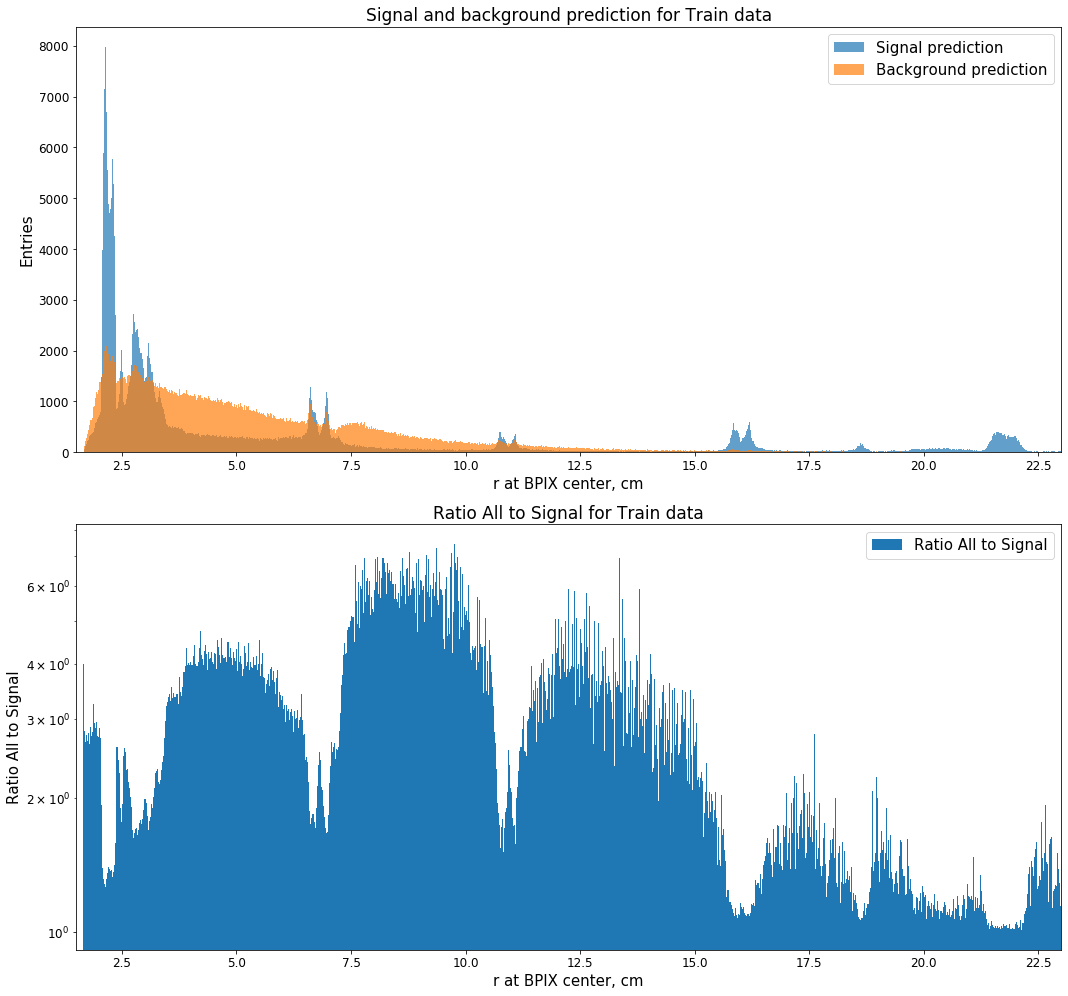

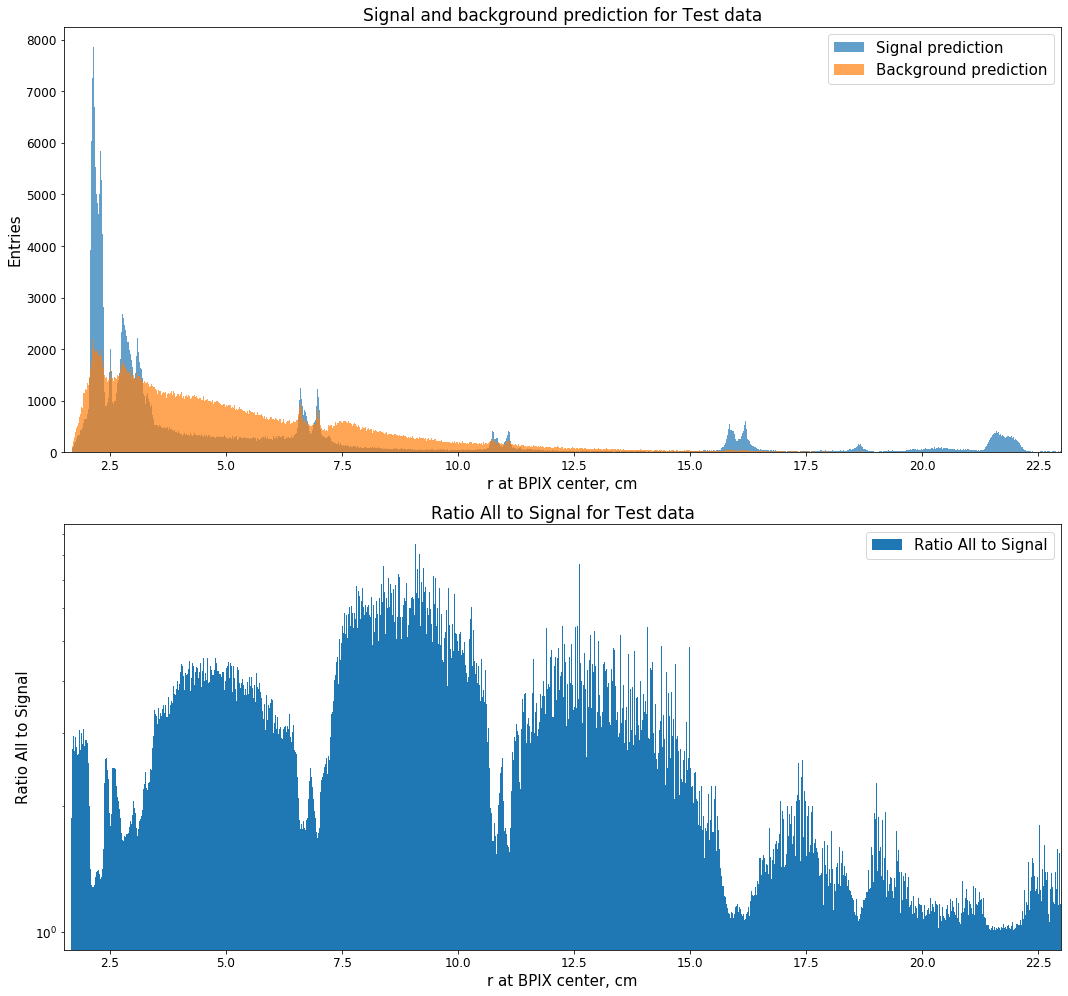

In [137]:
def PlotR_pred(Rad, Y_pred, Rmin, Rmax, Tit, nb):
    # using the variable ax for single a Axes
    fig, (ax,bx) = plt.subplots(2,1, figsize=(15,14))
    num_bins = nb
    transperance = 0.7
    

    #Signal
#     n, bins, patches = ax.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
#                                                        np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses))], num_bins)


    n_Sig, bins, patches = ax.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
                                                  np.logical_and(Y_pred > -1, Y_pred < numSig))], 
                               num_bins, range =[Rmin,Rmax], alpha = transperance)
    
    n_Bkg, bins, patches = ax.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
                                                       np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses))], 
                               num_bins, range =[Rmin,Rmax], alpha = transperance)

    # ratio of All to Signal give 0 is divide by 0:
    weights_Divide = np.divide((n_Sig+n_Bkg), n_Sig, out=np.zeros_like((n_Sig+n_Bkg)), where=n_Sig!=0)
#     weights_Divide = np.divide(n_Bkg, n_Sig, out=np.zeros_like(n_Bkg), where=n_Sig!=0)
    
    n_AllToSig, bins, patches = bx.hist(bins[:-1], bins, weights=weights_Divide)

    # calculate ratio of Background callified events to Signal classified events
            
    Xtitle = 'r at BPIX center, cm'
    Ytitle = 'Entries'
    ax.set_xlabel(Xtitle)
    ax.set_ylabel(Ytitle)
    ax.set_title("Signal and background prediction for "+ Tit + " data")
    ax.legend(['Signal prediction', 'Background prediction'], loc='upper right')
    ax.set_xlim(Rmin,Rmax)


    bx.set_xlabel(Xtitle)
    bx.set_ylabel("Ratio All to Signal")
    bx.set_title("Ratio All to Signal for "+ Tit + " data")
    bx.legend(['Ratio All to Signal'], loc='upper right')
    bx.set_xlim(Rmin,Rmax)
    bx.set_yscale('log')
    
    #plt.legend(['Signal prediction', 'Background prediction'], loc='upper right')
    #plt.xscale('log')

    fig.tight_layout()

    plt.savefig('Results/' + ModelName + '_' + Tit + '_Pred.pdf')
    plt.show()


PlotR_pred(Radius_BPIX_Train, Y_Train_pred, 1.5, 23., "Train", 1000)

PlotR_pred(Radius_BPIX_Test, Y_Test_pred, 1.5, 23.,"Test", 1000)
#PlotR_pred(Radius_BP_Test, Y_Test_pred, 1.5, 3.,"Test", 400)
#PlotR_pred(Radius_Tube_Test, Y_Test_pred, 17., 21.,"Test", 100)


### Tracker tomography with Test set for Signal-Background seperation in x-y plane <a class="anchor" id="PlotPredictedTomography"></a>

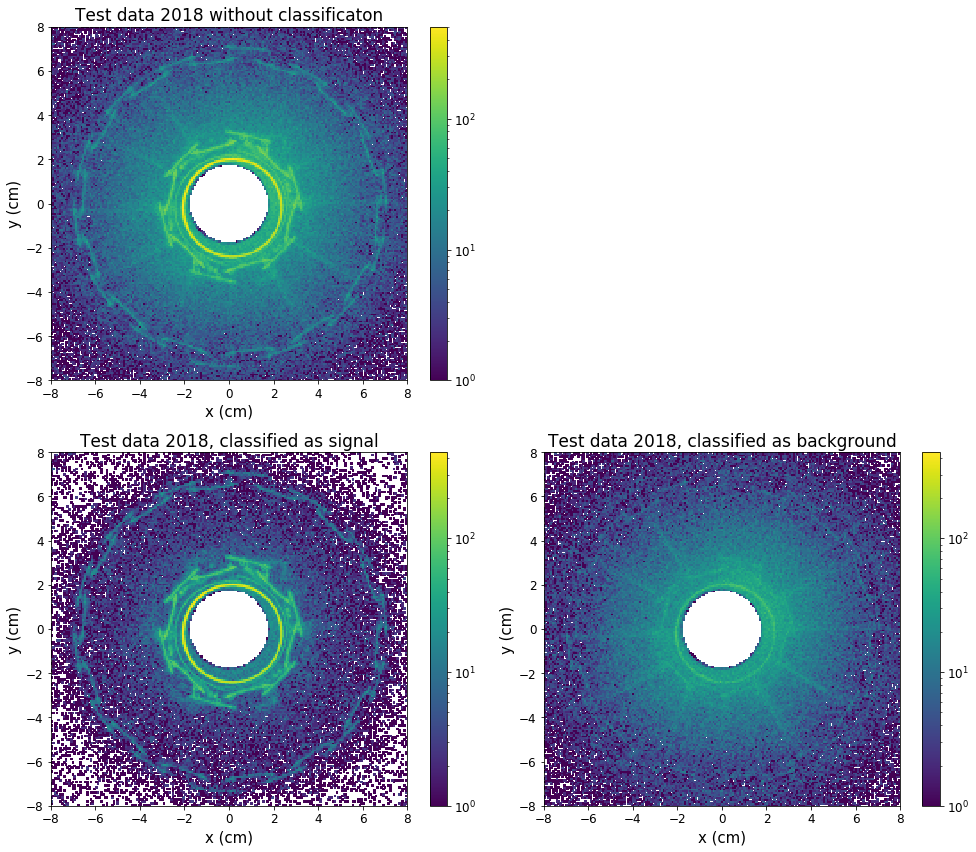

In [138]:
from matplotlib.colors import LogNorm

def PlotXY(x, y, Y_pred, Xmax, Tit, nb):
    # using the variable ax for single a Axes
    fig, ((ax, a_null),(bx,dx)) = plt.subplots(2,2, figsize=(14,12))
    fig.delaxes(a_null)
    #fig.delaxes(dx)
    num_bins = nb

# to add color pallete to figure: cmap = 'viridis' (default), 'jet'    
#     counts, xedges, yedges, im = ax.hist2d(x, y, bins=nb, range = [[-Xmax, Xmax], [-Xmax, Xmax]], norm=LogNorm())
    counts, xedges, yedges, im = ax.hist2d(x, y, bins=nb, range = [[-Xmax, Xmax], [-Xmax, Xmax]], norm=LogNorm(),
                                          cmap = 'viridis')
#     counts, xedges, yedges, im = ax.hist2d(x, y, bins=nb, range = [[-Xmax, Xmax], [-Xmax, Xmax]],cmap=plt.cm.jet, norm=LogNorm())

    counts, xedges, yedges, im2 = bx.hist2d(x[np.logical_and(Y_pred > -1, Y_pred < numSig)], 
                                           y[np.logical_and(Y_pred > -1, Y_pred < numSig)], bins=nb, range = [[-Xmax, Xmax], [-Xmax, Xmax]], norm=LogNorm())


    counts, xedges, yedges, im3 = dx.hist2d(x[np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses)], 
                                           y[np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses)], bins=nb, range = [[-Xmax, Xmax], [-Xmax, Xmax]], norm=LogNorm())

    vmin, vmax = im2.get_clim()
    im3.set_clim(vmin, vmax)
#     im2.set_clim(10, vmax)
#     im3.set_clim(10, vmax)
    plt.colorbar(im, ax=ax)
    plt.colorbar(im2, ax=bx)
    plt.colorbar(im3, ax=dx)

#     # set all of them to the same scale and max/2
#     vmin, vmax = im.get_clim()
#     im.set_clim(vmin, int(vmax/2))
#     im2.set_clim(vmin, int(vmax/2))
#     im3.set_clim(vmin, int(vmax/2))
#     plt.colorbar(im, ax=ax)
#     plt.colorbar(im2, ax=bx)
#     plt.colorbar(im3, ax=dx)
    

#     cax,kw = matplotlib.colorbar.make_axes([ax, bx, dx], location='right')
#     plt.colorbar(im, cax=cax, **kw)

#     fig.colorbar(im, ax=[ax,bx,dx])
    
    Xtitle = 'x (cm)'
    Ytitle = 'y (cm)'
    ax.set_xlabel(Xtitle)
    ax.set_ylabel(Ytitle)
    ax.set_title(Tit + " data 2018 without classificaton")
    bx.set_xlabel(Xtitle)
    bx.set_ylabel(Ytitle)
    bx.set_title(Tit + " data 2018, classified as signal")
    dx.set_xlabel(Xtitle)
    dx.set_ylabel(Ytitle)
    dx.set_title(Tit + " data 2018, classified as background")
#     ax.legend(['Signal prediction', 'Background prediction'], loc='upper right')
    
#     bx.set_xlabel(Xtitle, fontsize=fsize)
#     bx.set_ylabel(Ytitle, fontsize=fsize)
#     bx.set_title("Signal prediction for "+ Tit + " data by category: L2, L3 and L4", fontsize=fsize)
#     bx.legend(['L2 prediction', 'L3 prediction', 'L4 prediction'], loc='upper right', fontsize=fsize)


    #plt.xscale('log')
    #plt.yscale('log')
    fig.tight_layout()
    plt.savefig('Results/' + ModelName + '_' + Tit + '_XY_Pred.pdf')
    plt.show()

#PlotXY(X_Test[:,1], X_Test[:,2], Y_Test_pred, 25.,"Test", 1250)
# PlotXY(X_Test[:,1], X_Test[:,2], Y_Test_pred, 4.,"Test", 200)
PlotXY(X_Test[:,1], X_Test[:,2], Y_Test_pred, 8.,"Test", 200)
#PlotXY(X_Test[:,1], X_Test[:,2], Y_Test_pred, 25.,"Test", 625)
